# 1. Introduction <a name="introduction"></a>

In this Notebook, we address the exercise: **Forecasting Intra-Day Prices in the GB Power Market**.  
The goal is to predict the **Intra-Day Price (ID)**, which is published two hours before delivery, by leveraging various publicly available data sources (Day-Ahead prices, demand indicators, etc.).

## Why is the Intra-Day Price crucial?

- **Dispatch optimization**: Power producers and suppliers need to adjust their supply in near real-time to balance demand. An accurate forecast of the ID Price helps them determine the optimal quantities to inject or withdraw from the market at the right moment.
- **Risk management (hedging)**: Market participants (traders, utilities, etc.) rely on intra-day prices to hedge their positions or seize last-minute trading opportunities.
- **Grid stability**: A well-designed forecasting model also assists grid operators in anticipating supply-demand imbalances and minimizing the risk of system instability.

## Data and Study Period

- **Covered period**: From January 1, 2024, to February 15, 2025.  
- **Dataset size**: Approximately 35,000 rows after data cleaning and aggregation.  
- **Key columns**:  
  - *TSDF, NDF*: Demand forecasts (Transmission System Demand Forecast, National Demand Forecast).  
  - *INDDEM, MELNGC, IMBALNGC*: Indicated Demand, Margin, and Imbalance, providing insights into energy surplus or deficit.  
  - *SBP*: System Buy Price (our target variable for forecasting).  
  - *reserveScarcityPrice*: An indicator of market stress, which can significantly impact price spikes.  
  - *Other time-based variables* (hour, day, month, etc.) to capture seasonality patterns.

# 2. Imports and Configuration <a name="imports-and-configuration"></a>

In [132]:
import os
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import xgboost as xgb
import time
import matplotlib.dates as mdates

from io import StringIO
from scipy.stats import pearsonr
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from typing import List, Tuple, Dict, Any

# Configuration globale
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.max_columns = 50

# 3. Data loading <a name="data-loading"></a>

In [2]:
def generate_date_chunks(start_date, end_date, chunk_size_days=7):
    """
    Generates date intervals (start, end) with a maximum size of `chunk_size_days`. Useful for calling the API in small windows (7 days) to avoid rate limits.
    """
    start = pd.to_datetime(start_date)
    end   = pd.to_datetime(end_date)
    current = start
    
    while current <= end:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end:
            chunk_end = end
        yield (current.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d"))
        current = chunk_end + pd.Timedelta(days=1)

def fetch_demand_forecast_day_ahead_chunked(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
    Retrieves the Day-Ahead Demand Forecast (NDF, TSDF) by splitting the period into 7-day chunks using the endpoint /forecast/demand/day-ahead/latest.
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/demand/day-ahead/latest"
    all_dfs = []

    for (chunk_start, chunk_end) in generate_date_chunks(start_date, end_date, 7):
        params = {"from": f"{chunk_start}T00:00:00Z", "to":   f"{chunk_end}T23:59:59Z", "format": output_format}
        if boundary:
            params["boundary"] = boundary
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (use 'json' or 'csv').")
        else:
            print(f"[Warning] API Error [{r.status_code}] on {chunk_start} - {chunk_end}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()
    
    df_final = pd.concat(all_dfs, ignore_index=True)
    return df_final

def fetch_indicated_day_ahead_evolution_range(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
     Retrieves the Indicated Day-Ahead Forecast Evolution (INDDEM, INDGEN, IMBALNGC, MELNGC) using /forecast/indicated/day-ahead/evolution, iterating over each day + settlementPeriod=1..48.
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/indicated/day-ahead/evolution"
    sp_params = [("settlementPeriod", str(i)) for i in range(1, 49)]
    all_dfs = []
    
    date_range = pd.date_range(start_date, end_date, freq='D')
    for d in date_range:
        date_str = d.strftime("%Y-%m-%d")

        base_params = [("settlementDate", date_str), ("format", output_format)]
        params = base_params + sp_params
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                if isinstance(data_json, dict):
                    data_list = data_json.get("data", [])
                    if data_list:
                        df_chunk = pd.DataFrame(data_list)
                        all_dfs.append(df_chunk)
                else:
                    print(f"[Warning] Unexpected structure for date={date_str}: {type(data_json)}")
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (use 'json' or 'csv').")
        else:
            print(f"[Warning] API Error [{r.status_code}] for date={date_str}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()

    return pd.concat(all_dfs, ignore_index=True)

def fetch_system_prices_one_day(settlement_date: str, output_format: str = "json") -> pd.DataFrame:
    """
    Retrieves System Price (SBP, SSP, NIV) for a single day
    """
    base_url = f"https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/system-prices/{settlement_date}"
    params = {"format": output_format}

    r = requests.get(base_url, params=params)
    if r.status_code == 200:
        if output_format == "json":
            data_json = r.json()
            data = data_json.get("data", [])
            df = pd.DataFrame(data)
            return df
        elif output_format == "csv":
            df = pd.read_csv(StringIO(r.text))
            return df
        else:
            raise ValueError("Unsupported format (use 'json' or 'csv').")
    else:
        print(f"[Warning] API Error ({r.status_code}) for {settlement_date}: {r.text}")
        return pd.DataFrame()

def fetch_system_prices_range_day_by_day(start_date: str, end_date: str, output_format="json") -> pd.DataFrame:
    """
    Loops over each day between start_date and end_date to retrieve System Prices (SBP, SSP, NIV) via fetch_system_prices_one_day.
    """
    date_range = pd.date_range(start_date, end_date, freq='D')
    list_sp = []
    for d in date_range:
        d_str = d.strftime("%Y-%m-%d")
        df_day = fetch_system_prices_one_day(d_str, output_format=output_format)
        if not df_day.empty:
            list_sp.append(df_day)
    if list_sp:
        return pd.concat(list_sp, ignore_index=True)
    else:
        return pd.DataFrame()

def fetch_market_index_data_chunked(start_date: str, end_date: str, data_providers: list = ["N2EXMIDP"], chunk_size_days: int = 7, output_format: str = "json" ) -> pd.DataFrame: # or data_providers: list = ["N2EXMIDP","APXMIDP"]
    """
    Retrieves Market Index Data (MID) via /datasets/MID by segmenting the period [start_date, end_date] into `chunk_size_days` chunks
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/MID"
    all_dfs = []

    for (chunk_start, chunk_end) in generate_date_chunks(start_date, end_date, chunk_size_days):
        params = { "from": f"{chunk_start}T00:00:00Z", "to":   f"{chunk_end}T23:59:59Z", "format": output_format}

        dp_tuples = [("dataProviders", dp) for dp in data_providers]
        params_list = list(params.items()) + dp_tuples

        r = requests.get(base_url, params=params_list)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (choose 'json' or 'csv').")
        else:
            print(f"[Warning] API MID Error [{r.status_code}] from {chunk_start} to {chunk_end}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()

    df_final = pd.concat(all_dfs, ignore_index=True)
    return df_final

def fetch_fuelhh_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """
    Retrieves half-hourly generation outturn (FUELHH) via /datasets/FUELHH, segmenting the period [start_date, end_date]
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/FUELHH"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = { "settlementDateFrom": current.strftime("%Y-%m-%d"), "settlementDateTo":   chunk_end.strftime("%Y-%m-%d"), "format": output_format}
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (json or csv).")
        else:
            print(f"[Warning] FUELHH: HTTP {r.status_code} for {current.date()} to {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

def pivot_fuelhh(df_fuelhh: pd.DataFrame) -> pd.DataFrame:
    """
    Pivots the data to have one row per (settlementDate, settlementPeriod, startTime), with fuelType columns => generation
    """
    if df_fuelhh.empty:
        return df_fuelhh
    
    df_pivot = df_fuelhh.pivot_table(index=["settlementDate", "settlementPeriod", "startTime"], columns="fuelType", values="generation", aggfunc="mean").reset_index()
    
    for c in df_pivot.columns:
        if c not in ["settlementDate", "settlementPeriod", "startTime"]:
            df_pivot.rename(columns={c: f"gen_{c}"}, inplace=True)
    
    return df_pivot

def to_datetime_index_fuelhh(df: pd.DataFrame, time_col="startTime") -> pd.DataFrame:
    """
    Converts the FUELHH pivot table to a datetime index (column 'startTime' => 'datetime')
    """
    if df.empty:
        return df
    
    if time_col in df.columns:
        df["datetime"] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
    else:
        if {"settlementDate","settlementPeriod"}.issubset(df.columns):
            df["datetime"] = (pd.to_datetime(df["settlementDate"]) + pd.to_timedelta((df["settlementPeriod"] - 1)*30, unit='m'))
        else:
            df["datetime"] = pd.NaT
    
    df.set_index("datetime", inplace=True)
    return df

def fetch_windfor_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """ Retrieves wind forecast (WINDFOR) by segmenting the period [start_date, end_date] """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/WINDFOR"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = {"publishDateTimeFrom": current.strftime("%Y-%m-%dT00:00Z"), "publishDateTimeTo":   chunk_end.strftime("%Y-%m-%dT23:59Z"), "format": output_format}
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (choose 'json' or 'csv').")
        else:
            print(f"[Warning] WINDFOR: HTTP {r.status_code} for {current.date()} - {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

def fetch_loss_of_load_chunked(start_date: str, end_date: str, chunk_size_days: int = 7, output_format: str = "json") -> pd.DataFrame:
    """ Retrieves Loss of Load Probability (LoLP) & De-rated Margin (LOLPDRM) via /forecast/system/loss-of-load """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/system/loss-of-load"
    all_dfs = []
    
    current = pd.to_datetime(start_date)
    end_dt  = pd.to_datetime(end_date)
    
    while current <= end_dt:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end_dt:
            chunk_end = end_dt
        
        params = {"from": f"{current.strftime('%Y-%m-%d')}T00:00Z", "to":   f"{chunk_end.strftime('%Y-%m-%d')}T23:59Z", "format": output_format}
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Unsupported format (json or csv).")
        else:
            print(f"[Warning] LOLPDRM: HTTP {r.status_code} for {current.date()} - {chunk_end.date()}: {r.text}")
        
        current = chunk_end + pd.Timedelta(days=1)
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

#### Aggregation functions (Pick Indicated Forecast T-2h) and Final Merge

In [4]:
def to_datetime_index(df, time_col="startTime", date_col="settlementDate", period_col="settlementPeriod"):
        if df.empty:
            return df
        if time_col in df.columns:
            df["datetime"] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
        else:
            if date_col in df.columns and period_col in df.columns:
                df["datetime"] = (pd.to_datetime(df[date_col]) + pd.to_timedelta((df[period_col] - 1)*30, unit='m'))
            else:
                df["datetime"] = pd.NaT
        return df
    
def pick_indicated_forecast_t_minus_2h(df_indicated: pd.DataFrame) -> pd.DataFrame:
    """
    Filters df_indicated to retain only one publication per (settlementDate, settlementPeriod, startTime):
      - Calculate T-2h = startTime - 2 hours
      - Keep rows where publishTime <= T-2h
      - Among them, select the one with the latest publishTime (the most recent before T-2h)
    """
    if df_indicated.empty:
        return df_indicated

    df_indicated["publishTime_utc"] = pd.to_datetime(df_indicated["publishTime"], utc=True, errors="coerce")
    df_indicated["startTime_utc"]   = pd.to_datetime(df_indicated["startTime"],   utc=True, errors="coerce")

    df_indicated["T_minus_2h"] = df_indicated["startTime_utc"] - pd.Timedelta(hours=2)

    df_filtered = df_indicated[df_indicated["publishTime_utc"] <= df_indicated["T_minus_2h"]].copy()

    if df_filtered.empty:
        return df_filtered  # No publication <= T-2h?

    # For each (settlementDate, settlementPeriod, startTime_utc), select the most recent publication (maximum publishTime_utc)
    df_filtered.sort_values("publishTime_utc", inplace=True)
    df_unique = df_filtered.groupby(
        ["settlementDate","settlementPeriod","startTime_utc"], as_index=False
    ).tail(1).copy()

    df_unique.drop(columns=["publishTime_utc","startTime_utc","T_minus_2h"], inplace=True, errors="ignore")

    return df_unique

def merge_data_for_period(start_date: str, end_date: str, output_format="json", fetch_mid: bool = True, data_providers: list = None, fetch_fuelhh: bool = False, 
                          fetch_windfor: bool = False, fetch_lolpdrm: bool = False, chunk_size_days: int = 7, cache_folder="cache") -> pd.DataFrame:
    cache_filename = f"df_merged_{start_date}_{end_date}_mid={fetch_mid}_fuelhh={fetch_fuelhh}_wind={fetch_windfor}_lolp={fetch_lolpdrm}.pkl"
    cache_path = os.path.join(cache_folder, cache_filename)
    
    if os.path.exists(cache_path):
        print(f"[Cache] Loading final merged DataFrame from {cache_path}")
        with open(cache_path, "rb") as f:
            df_cached = pickle.load(f)
        return df_cached
    print("[Info] Cache not found. Fetching & merging data...")
    
    # A) Demand Forecast
    df_demand = fetch_demand_forecast_day_ahead_chunked(start_date, end_date, output_format=output_format)
    # B) Indicated Day-Ahead
    df_indicated = fetch_indicated_day_ahead_evolution_range(start_date, end_date, output_format=output_format)
    # C) System Prices
    df_system_prices = fetch_system_prices_range_day_by_day(start_date, end_date, output_format=output_format)
    # D) Market Index Data (MID)
    if fetch_mid:
        if data_providers is None:
            data_providers = ["N2EXMIDP"]  # Choix par défaut
        df_mid = fetch_market_index_data_chunked(start_date, end_date, data_providers=data_providers, chunk_size_days=chunk_size_days, output_format=output_format)
    else:
        df_mid = pd.DataFrame()

    # E) FUELHH
    if fetch_fuelhh:
        df_fuelhh_raw = fetch_fuelhh_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_fuelhh_pivot = pivot_fuelhh(df_fuelhh_raw)
        df_fuelhh_pivot = to_datetime_index_fuelhh(df_fuelhh_pivot)
    else:
        df_fuelhh_pivot = pd.DataFrame()

    # F) WINDFOR
    if fetch_windfor:
        df_windfor_raw = fetch_windfor_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_windfor = to_datetime_index(df_windfor_raw)
    else:
        df_windfor = pd.DataFrame()
    
    # G) LOLPDRM
    if fetch_lolpdrm:
        df_lolpdrm_raw = fetch_loss_of_load_chunked(start_date, end_date, chunk_size_days=chunk_size_days, output_format=output_format)
        df_lolpdrm = to_datetime_index(df_lolpdrm_raw)
    else:
        df_lolpdrm = pd.DataFrame()
        
    df_demand       = to_datetime_index(df_demand)
    df_indicated    = to_datetime_index(df_indicated)
    df_system_prices= to_datetime_index(df_system_prices)
    df_mid = to_datetime_index(df_mid)
    
    # Select T-2h publication in df_indicated
    df_indicated = pick_indicated_forecast_t_minus_2h(df_indicated)
    
    # Datetime in index
    for df_ in [df_demand, df_indicated, df_system_prices, df_mid, df_windfor, df_lolpdrm]:
        if not df_.empty and "datetime" in df_.columns:
            df_.set_index("datetime", inplace=True)

    if not df_demand.empty:
        df_demand.rename(columns={"transmissionSystemDemand": "TSDF", "nationalDemand": "NDF"}, inplace=True)
    if not df_indicated.empty:
        df_indicated.rename(columns={"indicatedDemand":"INDDEM", "indicatedGeneration":"INDGEN", "indicatedMargin":"MELNGC", "indicatedImbalance":"IMBALNGC"}, inplace=True)
    if not df_system_prices.empty:
        df_system_prices.rename(columns={"systemBuyPrice":"SBP", "systemSellPrice":"SSP", "netImbalanceVolume":"NIV"}, inplace=True)
    if not df_mid.empty:
        df_mid.rename(columns={"price": "MID_price", "volume": "MID_volume"}, inplace=True)
    if not df_windfor.empty:
        df_windfor.rename(columns={"generation": "windForecast"}, inplace=True)
    if not df_lolpdrm.empty:
        df_lolpdrm.rename(columns={"lossOfLoadProbability": "lolp"}, inplace=True)
    # Merge
    df_merge_1 = pd.merge(df_demand, df_indicated, how='outer', left_index=True, right_index=True, suffixes=("_dem","_ind"))
    df_merge_2 = pd.merge(df_merge_1, df_system_prices, how='outer', left_index=True, right_index=True, suffixes=("_m1","_m2"))
    df_merge_3 = pd.merge(df_merge_2, df_mid, how='outer', left_index=True, right_index=True, suffixes=("_m2","_mid"))
    df_merge_4 = pd.merge(df_merge_3, df_fuelhh_pivot, how='outer', left_index=True, right_index=True)
    df_merge_5 = pd.merge(df_merge_4, df_windfor,     how='outer', left_index=True, right_index=True)
    df_final   = pd.merge(df_merge_5, df_lolpdrm,     how='outer', left_index=True, right_index=True)
    df_final.sort_index(inplace=True)

    cols_to_drop = ["settlementDate_m2", "settlementPeriod_m2", "startTime_m2", "settlementDate_mid", "settlementPeriod_mid", "startTime_mid", "settlementDate_x", "settlementPeriod_x", "startTime_x", 
                    "settlementDate_y", "settlementPeriod_y", "startTime_y", "settlementDate_dem", "settlementPeriod_dem", "publishTime_dem", "startTime_dem", "settlementDate_ind", 
                    "settlementPeriod_ind", "publishTime_ind", "startTime_ind", "createdDateTime", "publishTime_x", "publishTime_y", "publishingPeriodCommencingTime", 
                    "dataset_x", "dataset_y", "dataProvider", "boundary_dem",  "boundary_ind"]
    df_final.drop(columns=cols_to_drop, inplace=True, errors="ignore")
    df_final.rename(columns={"settlementDate": "settlementDate_sys", "settlementPeriod": "settlementPeriod_sys", "startTime": "startTime_sys"}, inplace=True)

    os.makedirs(cache_folder, exist_ok=True)
    with open(cache_path, "wb") as f:
        pickle.dump(df_final, f)
    print(f"[Cache] Final DataFrame saved to {cache_path}")
    
    return df_final

In [6]:
start_time = time.time()

start_date = "2023-02-07"
end_date   = "2025-02-18"

df = merge_data_for_period(start_date, end_date, output_format="json", fetch_mid=True, data_providers=["APXMIDP"], fetch_fuelhh=True, 
                           fetch_windfor=True, fetch_lolpdrm=True, chunk_size_days=7)
print("--- %s seconds ---" % (time.time() - start_time))

[Info] Cache not found. Fetching & merging data...
[Cache] Final DataFrame saved to cache\df_merged_2023-02-07_2025-02-18_mid=True_fuelhh=True_wind=True_lolp=True.pkl
--- 1135.4837815761566 seconds ---


In [7]:
df.to_csv("df.csv")

In [35]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds temporal features (hour, dayofweek, month)
    """
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    return df

In [36]:
df = add_time_features(df)

# 4. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis-eda"></a>

In this section, we explore the distribution of key variables:
- **SBP** (System Buy Price, the target variable for prediction)
- **TSDF**, **NDF** (Demand Forecasts)
- **INDDEM**, **MELNGC**, **IMBALNGC** (Indicated Demand, Margin, Imbalance)
- etc.

**Objectives**:
1. Detect missing values,
2. Understand distribution (histograms), identify extreme peaks,
3. Analyze correlations,
4. Observe the temporal evolution of **SBP**.on temporellde **SBP**.


In [8]:
print("List of DataFrame columns:")
print(df.columns)

print("\nMissing values by column:")
missing_counts = df.isnull().sum()
print(missing_counts)

n_total = len(df)
missing_info = (missing_counts / n_total * 100).sort_values(ascending=False)
print("\nPercentage of NaN (top 20):")
print(missing_info.head(20))

Liste des colonnes du DataFrame:
Index(['TSDF', 'NDF', 'INDGEN', 'INDDEM', 'MELNGC', 'IMBALNGC', 'SSP', 'SBP',
       'bsadDefaulted', 'priceDerivationCode', 'reserveScarcityPrice', 'NIV',
       'sellPriceAdjustment', 'buyPriceAdjustment', 'replacementPrice',
       'replacementPriceReferenceVolume', 'totalAcceptedOfferVolume',
       'totalAcceptedBidVolume', 'totalAdjustmentSellVolume',
       'totalAdjustmentBuyVolume', 'totalSystemTaggedAcceptedOfferVolume',
       'totalSystemTaggedAcceptedBidVolume',
       'totalSystemTaggedAdjustmentSellVolume',
       'totalSystemTaggedAdjustmentBuyVolume', 'MID_price', 'MID_volume',
       'gen_BIOMASS', 'gen_CCGT', 'gen_COAL', 'gen_INTELEC', 'gen_INTEW',
       'gen_INTFR', 'gen_INTGRNL', 'gen_INTIFA2', 'gen_INTIRL', 'gen_INTNED',
       'gen_INTNEM', 'gen_INTNSL', 'gen_INTVKL', 'gen_NPSHYD', 'gen_NUCLEAR',
       'gen_OCGT', 'gen_OIL', 'gen_OTHER', 'gen_PS', 'gen_WIND',
       'windForecast', 'startTime_sys', 'forecastHorizon', 'lolp',
   

Observation: We observe that `replacementPrice` and `replacementPriceReferenceVolume` are largely empty (~85%). We will decide later whether to remove or impute them based on their relevance.

In [9]:
print("=== df.describe() ===")
display(df.describe())

print("\n=== df.info() ===")
print(df.info())

=== df.describe() ===


,TSDF,NDF,INDGEN,INDDEM,MELNGC,IMBALNGC,SSP,SBP,reserveScarcityPrice,NIV,sellPriceAdjustment,buyPriceAdjustment,totalAcceptedOfferVolume,totalAcceptedBidVolume,totalAdjustmentSellVolume,totalAdjustmentBuyVolume,totalSystemTaggedAcceptedOfferVolume,totalSystemTaggedAcceptedBidVolume,totalSystemTaggedAdjustmentBuyVolume,MID_price,MID_volume,gen_BIOMASS,gen_CCGT,gen_COAL,gen_INTELEC,gen_INTEW,gen_INTFR,gen_INTGRNL,gen_INTIFA2,gen_INTIRL,gen_INTNED,gen_INTNEM,gen_INTNSL,gen_INTVKL,gen_NPSHYD,gen_NUCLEAR,gen_OCGT,gen_OIL,gen_OTHER,gen_PS,gen_WIND,windForecast,forecastHorizon,lolp,deratedMargin
count,1.659972e+06,1.645040e+06,1.659762e+06,1.651707e+06,1.619673e+06,1.615583e+06,1.659887e+06,1.659887e+06,1.244191e+06,1.659887e+06,1659887.0,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659522e+06,1.659522e+06,1.305665e+06,1.659792e+06,1.659792e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,529434.000000,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.064300e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.659887e+06,1.571439e+06,1.659972e+06,1.659972e+06,1.659972e+06
mean,2.873540e+04,2.677254e+04,2.935670e+04,-1.895681e+04,2.999312e+04,6.254417e+02,8.465892e+01,8.465892e+01,5.644918e-01,-1.981093e+01,0.0,3.126209e-02,6.955577e+02,-7.623254e+02,-1.030488e+02,1.499950e+02,6.953163e+02,-7.620437e+02,1.905808e+02,8.340147e+01,1.916314e+03,1.933890e+03,9.640565e+03,1.950485e+02,4.615333e+02,-2.518309e+02,9.419297e+02,-22.959576,4.186080e+02,-2.586172e+02,2.098761e+02,3.933778e+02,1.062564e+03,4.196817e+02,3.962575e+02,4.322935e+03,1.922481e+01,1.790483e-02,3.633936e+02,-5.371949e+01,7.375877e+03,8.349083e+03,5.405276e+00,8.362393e-05,1.560054e+04
std,5.990004e+03,6.246637e+03,6.007321e+03,4.217348e+03,5.179183e+03,1.025248e+03,7.292136e+01,7.292136e+01,1.545432e+01,3.027050e+02,0.0,5.176322e-01,5.893232e+02,6.440444e+02,2.924995e+02,2.447019e+02,5.892316e+02,6.439133e+02,2.613528e+02,3.992378e+01,7.115637e+02,7.920627e+02,5.836439e+03,3.448045e+02,5.135787e+02,2.657987e+02,8.738530e+02,152.781783,5.134079e+02,2.507760e+02,6.586294e+02,6.039852e+02,5.752212e+02,7.333328e+02,2.486472e+02,7.128417e+02,6.448502e+01,1.100122e+00,2.837996e+02,6.673652e+02,4.213439e+03,4.938731e+03,4.082015e+00,3.265890e-03,6.033959e+03
min,1.689200e+04,1.388000e+04,1.473000e+04,-3.963900e+04,1.227500e+04,-5.120000e+03,-1.853300e+02,-1.853300e+02,0.000000e+00,-1.869258e+03,0.0,0.000000e+00,0.000000e+00,-4.047642e+03,-2.750000e+03,0.000000e+00,0.000000e+00,-4.046642e+03,0.000000e+00,-7.729000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.026000e+03,-5.320000e+02,-2.072000e+03,-514.000000,-1.030000e+03,-4.560000e+02,-1.092000e+03,-1.024000e+03,-1.454000e+03,-1.460000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.480000e+03,0.000000e+00,3.060000e+02,1.000000e+00,0.000000e+00,-3.678944e+02
25%,2.419300e+04,2.194000e+04,2.499200e+04,-2.122200e+04,2.617400e+04,-2.800000e+01,5.515000e+01,5.515000e+01,0.000000e+00,-1.857508e+02,0.0,0.000000e+00,2.430000e+02,-1.101035e+03,0.000000e+00,0.000000e+00,2.426425e+02,-1.100650e+03,0.000000e+00,6.635000e+01,1.389900e+03,1.309000e+03,4.516000e+03,0.000000e+00,0.000000e+00,-5.280000e+02,4.860000e+02,0.000000,-2.000000e+00,-4.520000e+02,-1.940000e+02,0.000000e+00,9.980000e+02,0.000000e+00,1.830000e+02,3.909000e+03,0.000000e+00,0.000000e+00,1.910000e+02,-3.200000e+02,3.783000e+03,3.987000e+03,2.000000e+00,0.000000e+00,1.101476e+04
50%,2.766300e+04,2.583800e+04,2.830800e+04,-1.832100e+04,3.000400e+04,6.280000e+02,8.498000e+01,8.498000e+01,0.000000e+00,-6.866700e+00,0.0,0.000000e+00,5.182107e+02,-5.823622e+02,0.000000e+00,3.077200e+01,5.183124e+02,-5.818346e+02,9.511100e+01,8.346000e+01,1.845850e+03,1.982000e+03,8.647000e+03,0.000000e+00,5.280000e+02,-2.960000e+02,1.002000e+03,0.000000,4.260000e+02,-3.700000e+02,1.480000e+02,5.540000e+02,1.398000e+03,5.660000e+02,3.700000e+02,4.368000e+03,


=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1660516 entries, 2023-02-07 00:00:00+00:00 to 2025-02-20 21:00:00+00:00
Data columns (total 51 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   TSDF                                   1659972 non-null  float64
 1   NDF                                    1645040 non-null  float64
 2   INDGEN                                 1659762 non-null  float64
 3   INDDEM                                 1651707 non-null  float64
 4   MELNGC                                 1619673 non-null  float64
 5   IMBALNGC                               1615583 non-null  float64
 6   SSP                                    1659887 non-null  float64
 7   SBP                                    1659887 non-null  float64
 8   bsadDefaulted                          1659887 non-null  object 
 9   priceDerivationCode                    1659887 n

- We see that the average `SBP` is around 80–90, with a minimum of -185 and a maximum of 2900 (extreme values).
- The columns `TSDF`, `NDF`, etc., range from ~16,000 to ~47,000.

#### Graphical analysis function

In [10]:
def plot_histograms(df: pd.DataFrame, cols_to_plot: list, bins: int = 50, figsize: tuple = (20,6)):
    df[cols_to_plot].hist(figsize=figsize, bins=bins, edgecolor="black")
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df: pd.DataFrame, corr_cols: list, figsize: tuple = (8,6)):
    corr = df[corr_cols].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap="RdBu", center=0)
    plt.title("Correlation Heatmap among selected features")
    plt.show()

def analyze_column(df: pd.DataFrame, col_name: str, sbp_col: str = "SBP"):
    n_rows = len(df)
    n_nan = df[col_name].isna().sum()
    frac_nan = n_nan / n_rows * 100
    
    print(f"=== Analyse for column: {col_name} ===")
    print(f"Total rows: {n_rows}, NaN count: {n_nan} ({frac_nan:.2f}%)")
    
    # Stats descriptives (sur valeurs non-nulles)
    non_null_data = df[col_name].dropna()
    if not non_null_data.empty and pd.api.types.is_numeric_dtype(non_null_data):
        print("\nDescriptive stats for non-null values:")
        print(non_null_data.describe())
    else:
        print("\nNon-numeric or empty. Skipping descriptive stats.")
    
    plt.figure(figsize=(12,4))
    non_null_data.hist(bins=50, edgecolor="black")
    plt.title(f"Histogram of {col_name} (non-null values)")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()

    # Relation avec SBP (scatter)
    if sbp_col in df.columns and pd.api.types.is_numeric_dtype(df[sbp_col]):
        plt.figure(figsize=(12,4))
        df_plot = df.dropna(subset=[col_name, sbp_col])
        plt.scatter(df_plot[col_name], df_plot[sbp_col], alpha=0.3)
        plt.title(f"{col_name} vs {sbp_col}")
        plt.xlabel(col_name)
        plt.ylabel(sbp_col)
        plt.show()
    
    print("\n" + "="*40 + "\n")

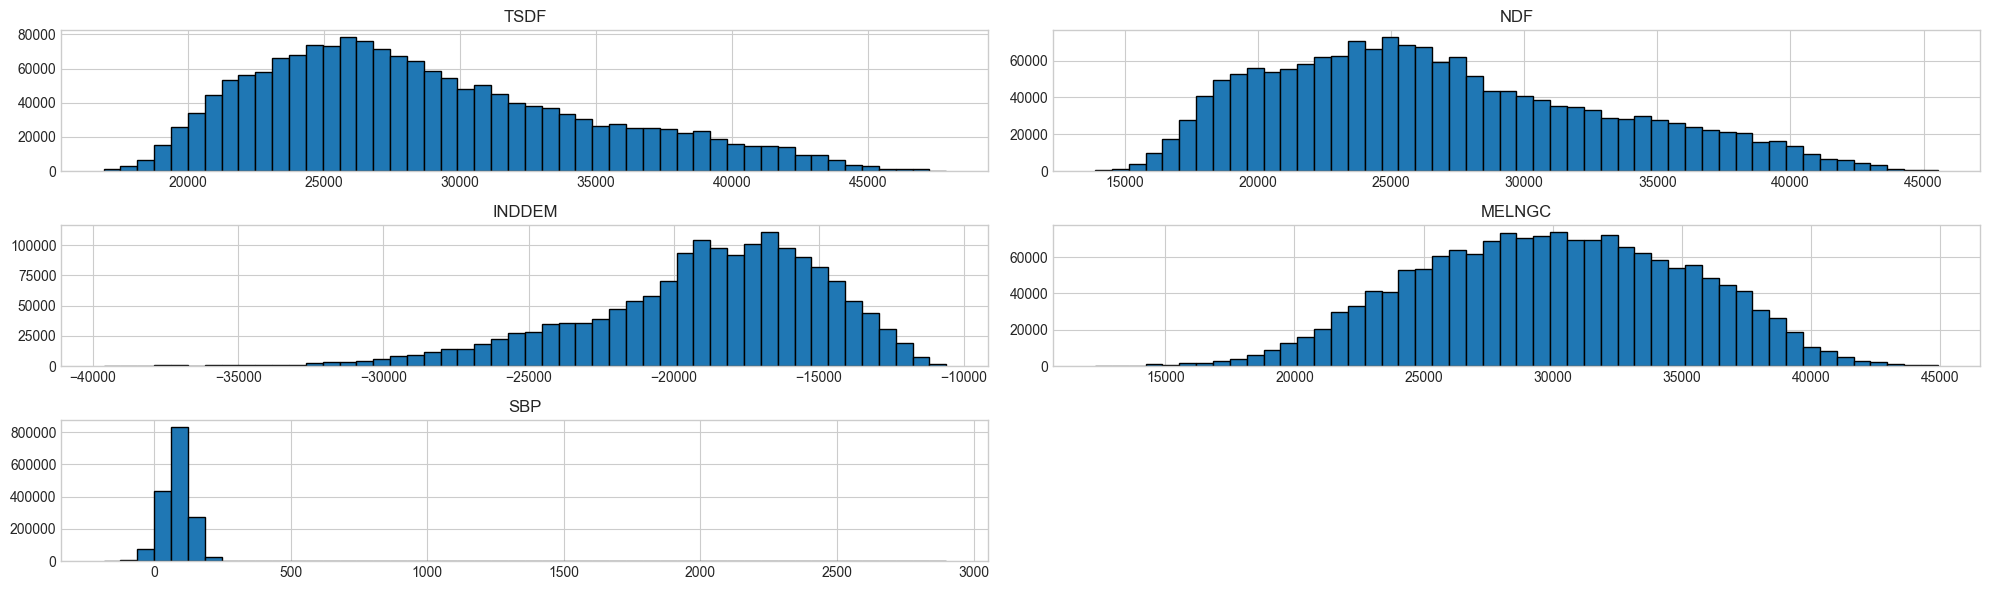

In [11]:
cols_to_plot = ["TSDF","NDF","INDDEM","MELNGC","SBP"]
plot_histograms(df, cols_to_plot=cols_to_plot, bins=50, figsize=(20,6))

- TSDF/NDF: centered around 25–30k.
- INDDEM: can be negative (down to -30,000).
- SBP: mostly between 0 and 200, but with peaks reaching up to 2900.

In [84]:
def plot_correlation_heatmap(df: pd.DataFrame, features: list, target_col: str = "SBP"):
    # Correlation matrix
    corr_df = df[features + [target_col]].corr(method="pearson")
    
    plt.figure(figsize=(1.2*len(features), 0.6*len(features)))
    sns.heatmap(corr_df, annot=True, cmap="RdBu", center=0)
    plt.title("Correlation Matrix (features + target)")
    plt.show()
    
    # target correlation (with p-value)
    results = []
    for f in features:
        # Remove NaN rows for the feature or the target
        sub_df = df[[f, target_col]].dropna()
        if sub_df.empty:
            continue
        # Pearson correlation + p-value
        corr_val, p_val = pearsonr(sub_df[f], sub_df[target_col])
        nb_non_null = len(sub_df)
        results.append((f, corr_val, p_val, nb_non_null))
    
    # Summary display
    res_df = pd.DataFrame(results, columns=["Feature", "Corr_with_target", "p_value", "Nb_non_null"])
    res_df.sort_values(by="Corr_with_target", ascending=False, inplace=True)
    
    print("\n=== Correlation vs Target (Pearson) ===")
    print(res_df.to_string(index=False))
    print()

def monthly_correlation(df: pd.DataFrame, feature: str, target_col: str = "SBP", plot_type: str = "line"):
    """
    Computes and plots the monthly correlation between `feature` and `target_col`.
    """
    sub_df = df[[feature, target_col]].dropna()
    if sub_df.empty:
        print(f"[Warning] No valid data for correlation: '{feature}' vs '{target_col}'.")
        return

    def monthly_corr(group):
        if len(group) < 2:
            return float("nan")
        return group[feature].corr(group[target_col])

    monthly_corr_series = sub_df.resample("M").apply(monthly_corr)
    monthly_corr_series.name = "Correlation"

    fig, ax = plt.subplots(figsize=(10, 5))
    if plot_type == "bar":
        ax.bar(monthly_corr_series.index, monthly_corr_series, width=15, color="skyblue", edgecolor="black")
        ax.set_title(f"Monthly Correlation ({feature} vs {target_col}) [Bar Chart]")
    else:
        ax.plot(monthly_corr_series.index, monthly_corr_series, marker="o", color="steelblue")
        ax.set_title(f"Monthly Correlation ({feature} vs {target_col}) [Line Chart]")
    
    ax.set_ylim([-1, 1])
    ax.axhline(0, color="black", linestyle="dashed")
    ax.set_ylabel("Correlation")
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

    print("=== Monthly Correlation Values ===")
    display(monthly_corr_series)

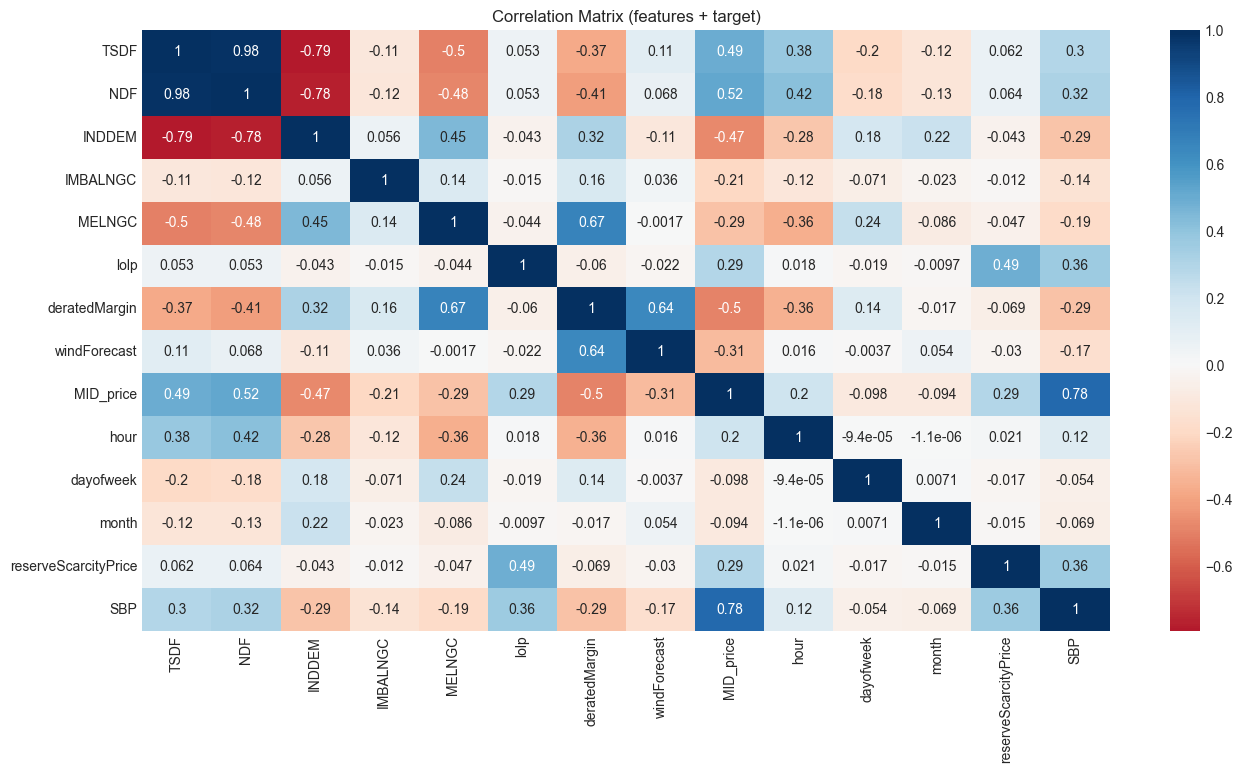


=== Correlation vs Target (Pearson) ===
             Feature  Corr_with_target  p_value  Nb_non_null
           MID_price          0.779094      0.0      1659707
                lolp          0.364181      0.0      1659887
reserveScarcityPrice          0.355484      0.0      1659887
                 NDF          0.315206      0.0      1644955
                TSDF          0.298363      0.0      1659887
                hour          0.124421      0.0      1659887
           dayofweek         -0.053569      0.0      1659887
               month         -0.069409      0.0      1659887
            IMBALNGC         -0.144136      0.0      1615498
        windForecast         -0.167420      0.0      1659677
              MELNGC         -0.187143      0.0      1619588
              INDDEM         -0.285270      0.0      1651622
       deratedMargin         -0.294872      0.0      1659887



In [85]:
corr_cols = ["TSDF", "NDF", "INDDEM", "IMBALNGC", "MELNGC", "lolp", "deratedMargin", "windForecast", "MID_price", "hour", "dayofweek", "month", "reserveScarcityPrice"]
plot_correlation_heatmap(df, features=corr_cols, target_col="SBP")

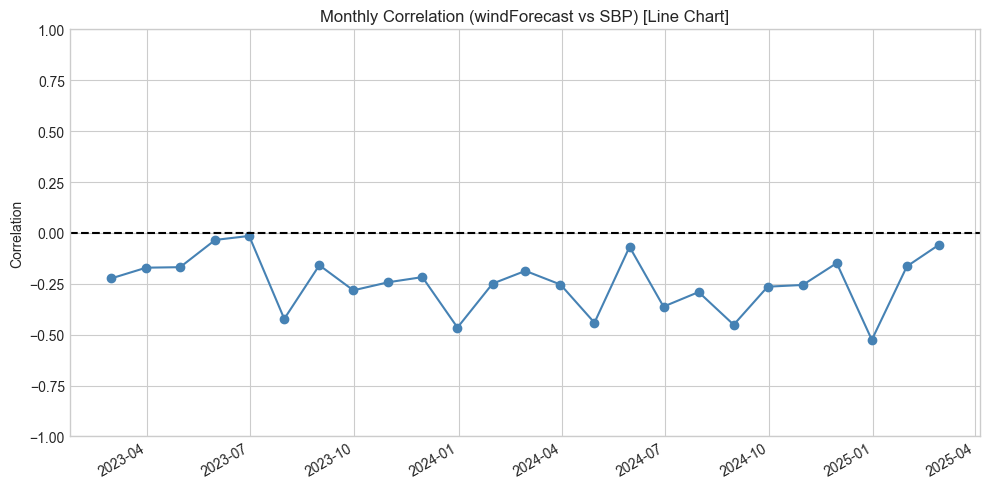

=== Monthly Correlation Values ===


datetime
2023-02-28 00:00:00+00:00   -0.223661
2023-03-31 00:00:00+00:00   -0.170731
2023-04-30 00:00:00+00:00   -0.168291
2023-05-31 00:00:00+00:00   -0.034304
2023-06-30 00:00:00+00:00   -0.014823
2023-07-31 00:00:00+00:00   -0.422237
2023-08-31 00:00:00+00:00   -0.158590
2023-09-30 00:00:00+00:00   -0.282040
2023-10-31 00:00:00+00:00   -0.242205
2023-11-30 00:00:00+00:00   -0.217080
2023-12-31 00:00:00+00:00   -0.464898
2024-01-31 00:00:00+00:00   -0.249135
2024-02-29 00:00:00+00:00   -0.186339
2024-03-31 00:00:00+00:00   -0.253646
2024-04-30 00:00:00+00:00   -0.441096
2024-05-31 00:00:00+00:00   -0.068321
2024-06-30 00:00:00+00:00   -0.362072
2024-07-31 00:00:00+00:00   -0.290464
2024-08-31 00:00:00+00:00   -0.451160
2024-09-30 00:00:00+00:00   -0.264046
2024-10-31 00:00:00+00:00   -0.255641
2024-11-30 00:00:00+00:00   -0.148233
2024-12-31 00:00:00+00:00   -0.525336
2025-01-31 00:00:00+00:00   -0.164093
2025-02-28 00:00:00+00:00   -0.059264
Freq: M, Name: Correlation, dtype: float6

In [82]:
monthly_correlation(df, feature="windForecast", target_col="SBP", plot_type="line")

#### Observations from the Correlation Analysis

1. **High Correlation with `SBP`**  
   - **`MID_price`** (0.78) is the most correlated feature, indicating that wholesale market prices closely track the system buy price.  
   - **`lolp`** (0.36) and **`reserveScarcityPrice`** (0.36) also show moderate positive correlations, reflecting that higher system stress or scarcity typically pushes SBP upward.

2. **Moderate Demand-Related Correlations**  
   - **`TSDF`** and **`NDF`** are highly correlated with each other (~0.98) and both partially explain SBP (0.30 and 0.32 respectively).  
   - **`INDDEM`** is strongly negatively correlated with TSDF/NDF (~-0.9), suggesting these demand forecasts capture somewhat different aspects of the load.  
   - Overall, **SBP** only shows moderate correlation (~0.2–0.3) with these demand measures, indicating that while demand is relevant, it does not fully determine price levels. Other factors—like supply conditions (**IMBALNGC**, **windForecast**) or system stress (**lolp**, **reserveScarcityPrice**)—are also critical.

3. **Negative Supply Factors**  
   - **`IMBALNGC`** (-0.14) and **`windForecast`** (-0.17) both show that greater surplus or wind availability tends to lower SBP. Monthly correlations for `windForecast` can intensify (down to -0.52), highlighting its seasonal influence.

4. **Time-Based Features**  
   - **`hour`** (0.12), **`dayofweek`** (-0.05), and **`month`** (-0.07) have weaker correlations but remain essential for capturing daily, weekly, and seasonal price patterns typical of electricity markets.

5. **Rationale for Feature Inclusion**  
   - Despite some moderate correlation values, these variables collectively capture demand (NDF, TSDF, INDDEM), supply (windForecast, IMBALNGC), system stress (lolp, reserveScarcityPrice), and time effects (hour, dayofweek, month). Together, they provide a more comprehensive perspective on price formation than relying on a single high-correlation driver.
relation driver.
nounced.


### Specific analysis of certain columns
For example, we examine massively empty or potentially useful columns:
- `reserveScarcityPrice`
- `replacementPrice`
- `replacementPriceReferenceVolume`
- `totalSystemTaggedAdjustmentSellVolume`
- `totalSystemTaggedAdjustmentBuyVolume`

=== Analyse for column: reserveScarcityPrice ===
Total rows: 1660516, NaN count: 416325 (25.07%)

Descriptive stats for non-null values:
count    1.244191e+06
mean     5.644918e-01
std      1.545432e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.088160e+03
Name: reserveScarcityPrice, dtype: float64


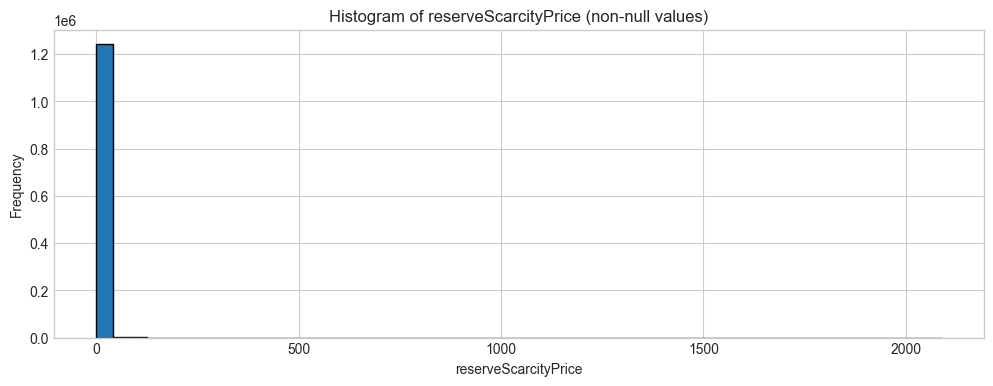

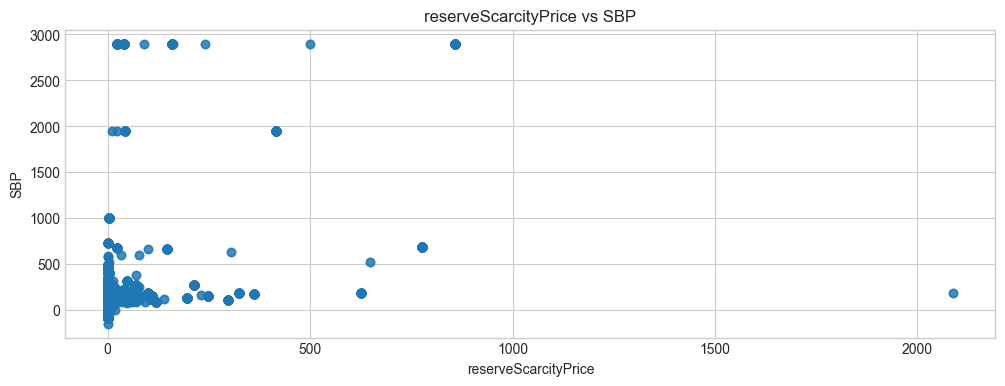



=== Analyse for column: replacementPrice ===
Total rows: 1660516, NaN count: 1362014 (82.02%)

Non-numeric or empty. Skipping descriptive stats.


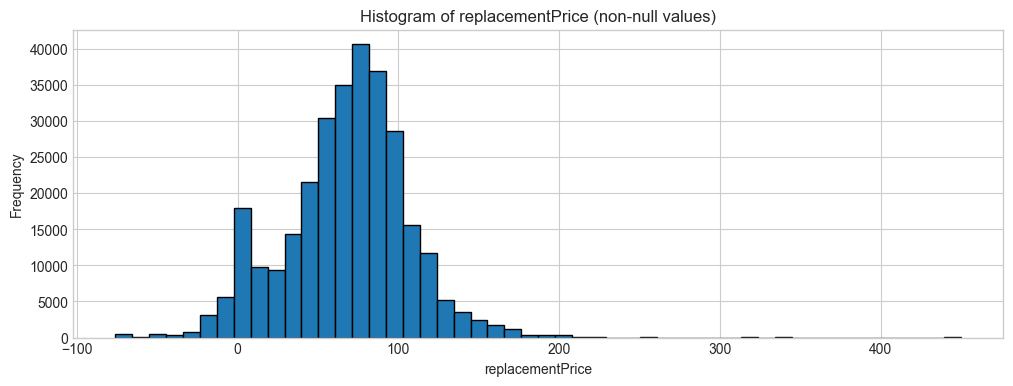

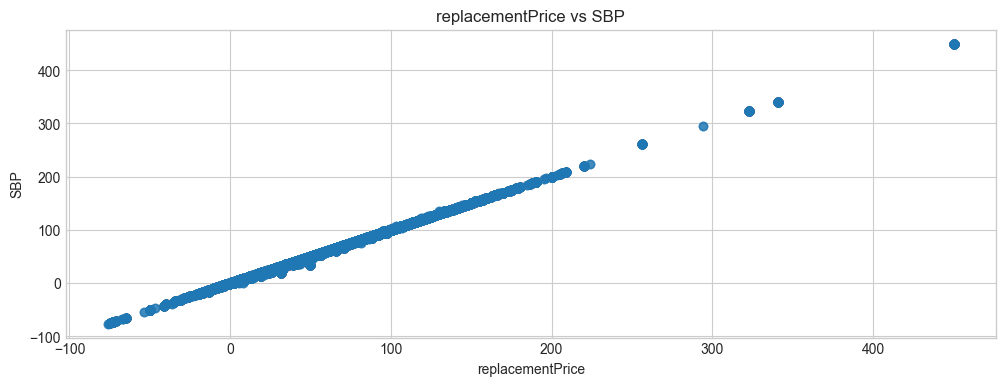



=== Analyse for column: replacementPriceReferenceVolume ===
Total rows: 1660516, NaN count: 1362014 (82.02%)

Non-numeric or empty. Skipping descriptive stats.


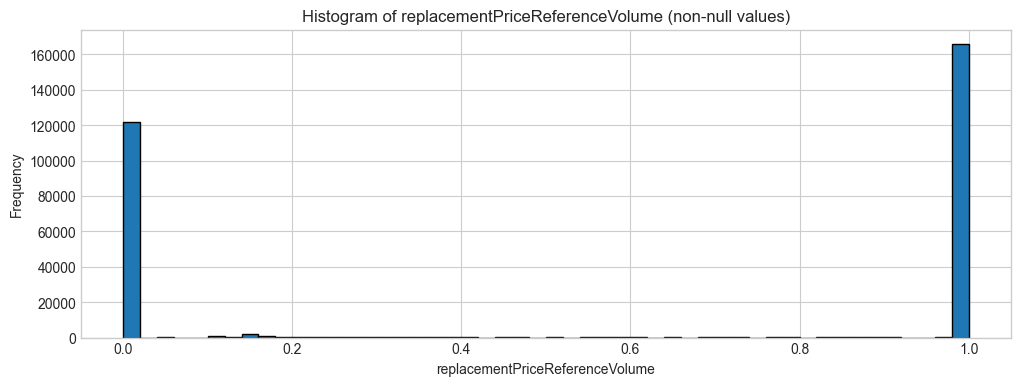

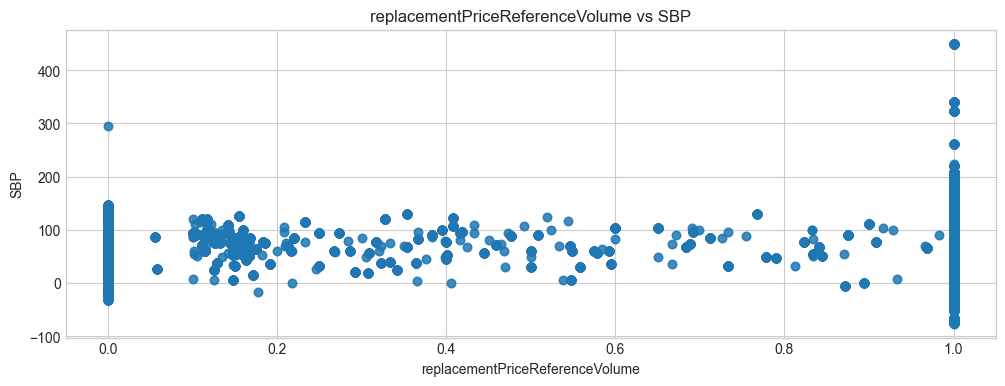



=== Analyse for column: totalSystemTaggedAdjustmentSellVolume ===
Total rows: 1660516, NaN count: 678059 (40.83%)

Non-numeric or empty. Skipping descriptive stats.


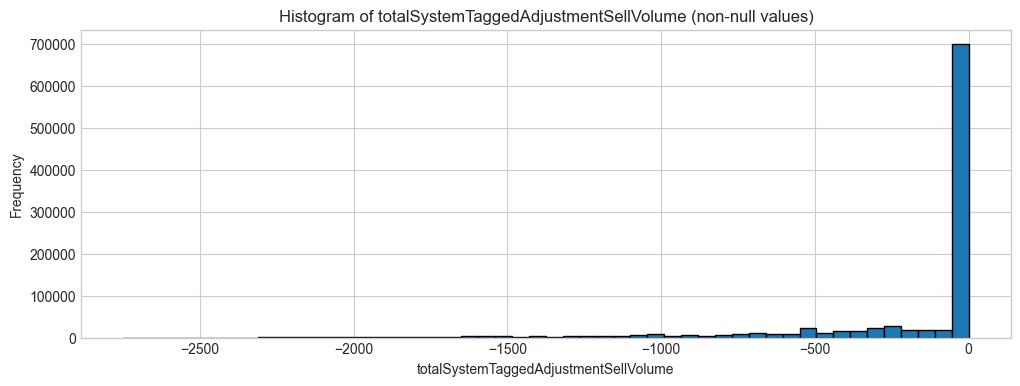

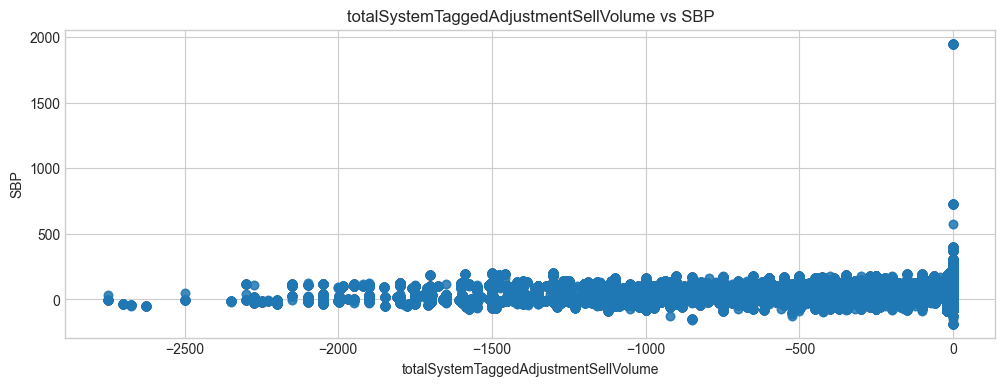



=== Analyse for column: totalSystemTaggedAdjustmentBuyVolume ===
Total rows: 1660516, NaN count: 354851 (21.37%)

Descriptive stats for non-null values:
count    1.305665e+06
mean     1.905808e+02
std      2.613528e+02
min      0.000000e+00
25%      0.000000e+00
50%      9.511100e+01
75%      2.752000e+02
max      3.099000e+03
Name: totalSystemTaggedAdjustmentBuyVolume, dtype: float64


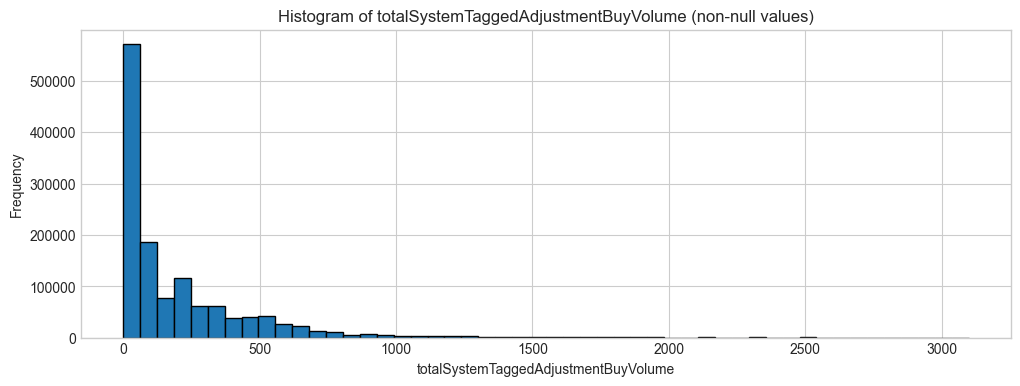

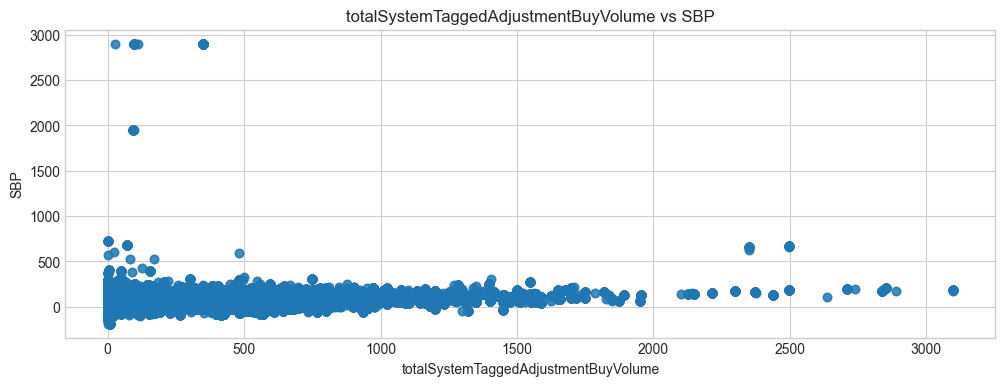

In [13]:
cols_to_analyze = ["reserveScarcityPrice", "replacementPrice", "replacementPriceReferenceVolume", "totalSystemTaggedAdjustmentSellVolume", "totalSystemTaggedAdjustmentBuyVolume"]

for col in cols_to_analyze:
    analyze_column(df, col_name=col, sbp_col="SBP")

| **Column**                                | **% of NaN** | **Analysis**                                                                                       | **Decision**                                   |
|-------------------------------------------|-------------:|----------------------------------------------------------------------------------------------------|------------------------------------------------|
| **reserveScarcityPrice**                  | 27.0%        | Mostly 0, with a few rare peaks. Slight correlation with some SBP peaks.                           | Keep and impute NaN with 0.                    |
| **replacementPrice**                      | 82.0%        | Distribution ~0–200, strong correlation with SBP in the non-zero portion. Very little usable data. | Remove (too many missing values).              |
| **replacementPriceReferenceVolume**       | 82.0%        | Often 0 or 1, weak correlation with SBP. Same issue as `replacementPrice`.                         | Remove.                                        |
| **totalSystemTaggedAdjustmentSellVolume** | 36.0%        | Wide range (negative/positive), no clear relationship with SBP.                                    | Remove (uncertain imputation).                 |
| **totalSystemTaggedAdjustmentBuyVolume**  | 20.0%        | Values mostly <500, weak correlation. Possible to impute to 0, but removal is preferred.           | Remove.                                        |

**Summary**: We **retain** `reserveScarcityPrice` (with 0 imputation) and **remove** the other columns.

=== Analyse for column: gen_INTGRNL ===
Total rows: 1660516, NaN count: 1131082 (68.12%)

Descriptive stats for non-null values:
count    529434.000000
mean        -22.959576
std         152.781783
min        -514.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         506.000000
Name: gen_INTGRNL, dtype: float64


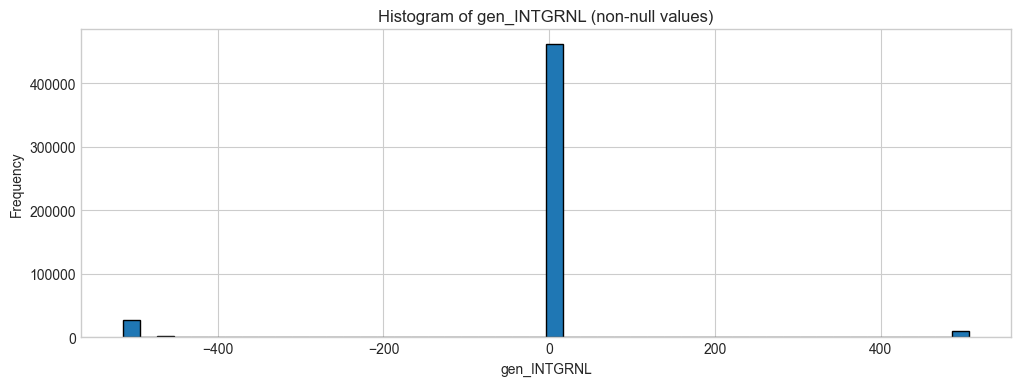

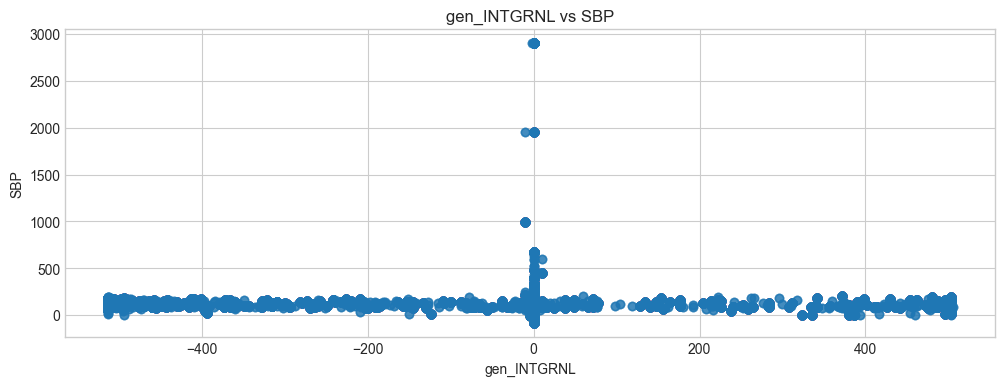



=== Analyse for column: gen_INTVKL ===
Total rows: 1660516, NaN count: 596216 (35.91%)

Descriptive stats for non-null values:
count    1.064300e+06
mean     4.196817e+02
std      7.333328e+02
min     -1.460000e+03
25%      0.000000e+00
50%      5.660000e+02
75%      9.880000e+02
max      1.436000e+03
Name: gen_INTVKL, dtype: float64


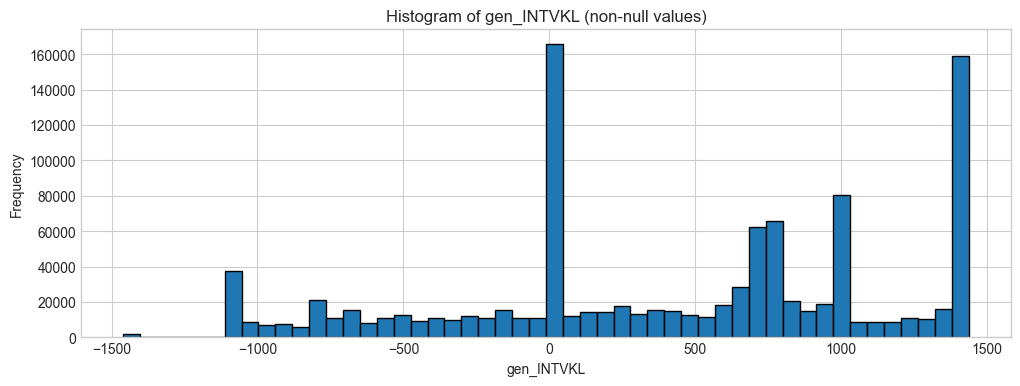

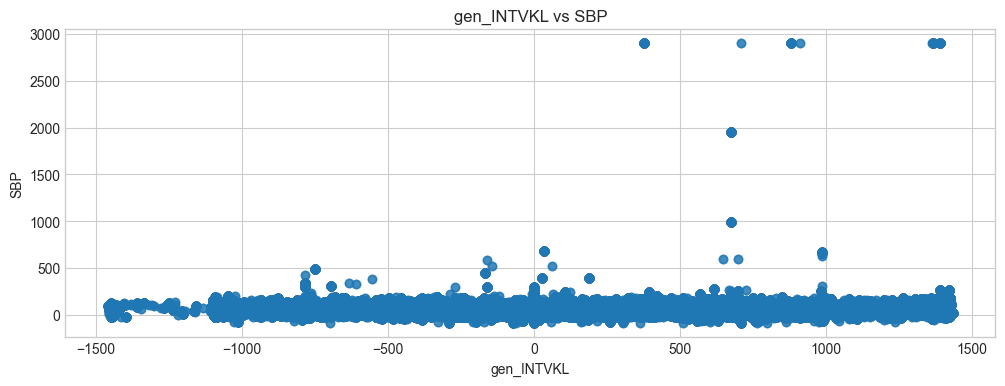



=== Analyse for column: windForecast ===
Total rows: 1660516, NaN count: 89077 (5.36%)

Descriptive stats for non-null values:
count    1.571439e+06
mean     8.349083e+03
std      4.938731e+03
min      3.060000e+02
25%      3.987000e+03
50%      7.655000e+03
75%      1.221100e+04
max      2.049900e+04
Name: windForecast, dtype: float64


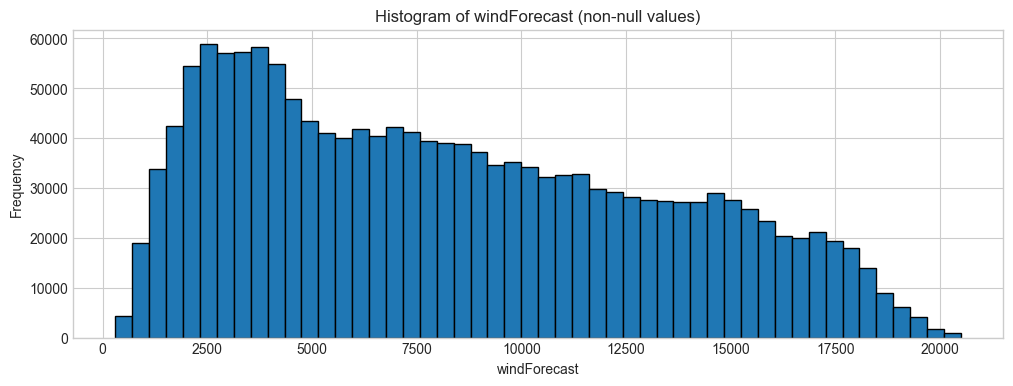

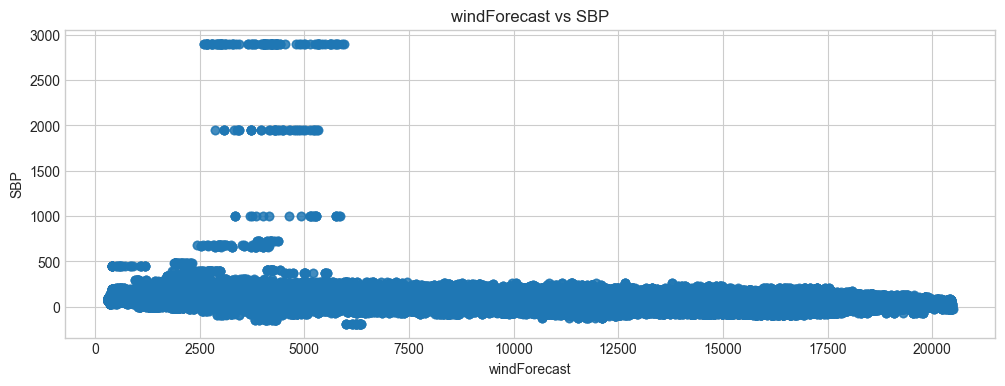

In [14]:
cols_to_analyze = ["gen_INTGRNL", "gen_INTVKL", "windForecast"]

for col in cols_to_analyze:
    analyze_column(df, col_name=col, sbp_col="SBP")

| **Column**        | **% of NaN** | **Analysis**                                                                                      | **Decision**                                   |
|-------------------|-------------:|---------------------------------------------------------------------------------------------------|------------------------------------------------|
| **gen_INTGRNL**   | 68.1%        | Mostly 0, little variability, weak correlation with SBP.                                          | Remove.                                       |
| **gen_INTVKL**    | 35.9%        | Greater variability, some significant peaks.                                                      | Remove.                                       |
| **windForecast**  | 5.36%        | Clear correlation with SBP, potential impact on price volatility.                                 | Keep and interpolate NaNs.                    |

#### Key Findings from EDA

- **Negative SBP (~5%)**: Around 5% of SBP values are below 0, mostly occurring at night (0–4 AM) and on weekends (day 6 = Sunday). This often indicates an oversupply (low demand) leading to negative prices.  
- **Strong TSDF–NDF correlation (~0.98)**: Both demand forecasts overlap significantly.  
- **Extreme peaks (SBP > 2000)**: A few rare events reach 2,500–3,000, increasing volatility and impacting RMSE.  
- **IMBALNGC, MELNGC, INDDEM variables**: They exhibit a moderate correlation with SBP (typically -0.15 to -0.30), reflecting the impact of surplus/deficit. However, no single variable fully explains fluctuations.  
- **Temporal distribution**: Negative values and peaks occur throughout the period but exhibit marked seasonality (night, weekends, potentially specific months).  

In summary, the market presents:
- A highly skewed SBP distribution (concentration around 0–100 with some extreme peaks).  
- Strong correlations between some demand variables (TSDF, NDF), but weaker links with SBP.  
- Significant missing values in certain columns (e.g., replacementPrice), justifying their removal or imputation.  

These observations guide our **feature engineering** choices (adding temporal variables, handling extreme values) and **modeling strategy** (a model robust to high volatility, possible log-transform).

## 5. Data Cleaning and Preparation <a name="data-cleaning-and-preparation"></a>

In [19]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Specific cleaning of columns identified as massively empty or requiring imputation
    """
    # Imputation reserveScarcityPrice
    if "reserveScarcityPrice" in df.columns:
        df["reserveScarcityPrice"].fillna(0, inplace=True)
        print("[Info] reserveScarcityPrice: NaN -> 0.")
    
    # Deletion
    for col_to_drop in ["replacementPrice", "replacementPriceReferenceVolume", "totalSystemTaggedAdjustmentSellVolume", "totalSystemTaggedAdjustmentBuyVolume", "gen_INTGRNL", "gen_INTVKL",]:
        if col_to_drop in df.columns:
            df.drop(columns=[col_to_drop], inplace=True)
            print(f"[Info] {col_to_drop} dropped.")

    # windForecast : interpolation
    if "windForecast" in df.columns:
        df["windForecast"] = df["windForecast"].interpolate(method="time", limit_direction="forward")
        print("[Info] windForecast: NaN interpolated (method='time').")
        
    return df

In [20]:
df = clean_columns(df)

[Info] reserveScarcityPrice: NaN -> 0.
[Info] replacementPrice dropped (massively missing).
[Info] replacementPriceReferenceVolume dropped (massively missing).
[Info] totalSystemTaggedAdjustmentSellVolume dropped (~36% missing).
[Info] totalSystemTaggedAdjustmentBuyVolume dropped (~20% missing).
[Info] gen_INTGRNL dropped (~68% missing).
[Info] gen_INTVKL dropped (~36% missing).
[Info] windForecast: NaN interpolated (method='time').


In [86]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Deletes rows where certain key columns are NaN
    """
    required_cols = ["SBP", "NDF", "INDDEM", "MELNGC", "IMBALNGC", "totalSystemTaggedAcceptedOfferVolume", "totalSystemTaggedAcceptedBidVolume", "windForecast", "lolp", "MID_price", "deratedMargin"]
    df = df.dropna(subset=required_cols).copy()
    return df

In [87]:
df = handle_missing_values(df)

#### Why are there negative SBPs and what can be done?

In [88]:
def check_negative_sbp(df: pd.DataFrame, sbp_col: str = "SBP"):
    neg_count = (df[sbp_col] < 0).sum()
    total = len(df)
    if neg_count > 0:
        print(f"[check_negative_sbp] Found {neg_count} negative SBP values out of {total} "
              f"({100*neg_count/total:.2f}%).")
        print(df.loc[df[sbp_col] < 0, sbp_col].describe())
    else:
        print("[check_negative_sbp] No negative SBP found.")

In [89]:
check_negative_sbp(df)

[check_negative_sbp] Found 78800 negative SBP values out of 1593078 (4.95%).
count    78800.000000
mean       -23.603082
std         22.060808
min       -185.330000
25%        -29.560000
50%        -19.000000
75%         -7.410000
max         -0.080000
Name: SBP, dtype: float64


In [95]:
df_negative_sbp = df[df["SBP"] < 0][["TSDF", "NDF", "INDDEM", "MELNGC", "IMBALNGC", "hour", "dayofweek", "month", "reserveScarcityPrice", "SBP"]]

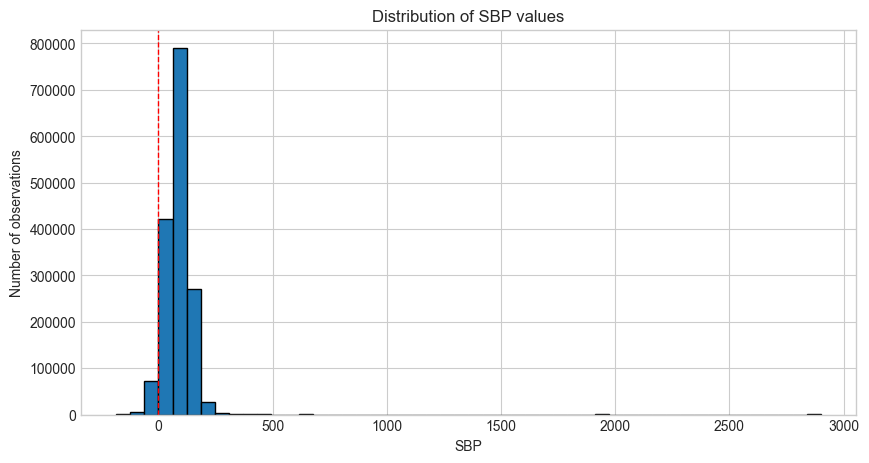

In [96]:
plt.figure(figsize=(10, 5))
df["SBP"].hist(bins=50, edgecolor="black")
plt.axvline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Distribution of SBP values")
plt.xlabel("SBP")
plt.ylabel("Number of observations")
plt.show()

- Most values are between 0 and 200, with some peaks above 1,000.
- ~5% are below 0, down to -185.

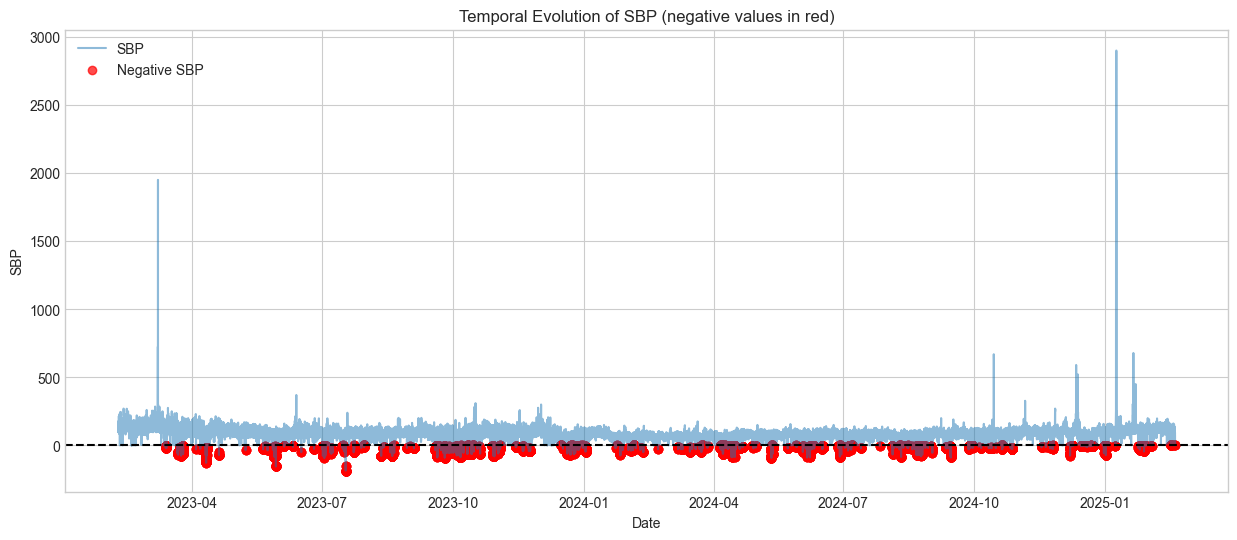

In [97]:
df["SBP_negative"] = df["SBP"] < 0
df_neg = df[df["SBP_negative"]]

plt.figure(figsize=(15, 6))
plt.plot(df.index, df["SBP"], label="SBP", alpha=0.5)
plt.scatter(df_neg.index, df_neg["SBP"], color="red", label="Negative SBP", alpha=0.7)
plt.axhline(0, color="black", linestyle="dashed")
plt.title("Temporal Evolution of SBP (negative values in red)")
plt.xlabel("Date")
plt.ylabel("SBP")
plt.legend()
plt.show()

- Negative SBPs are distributed throughout the entire period.  
- Extreme peaks (up to 2,900) are rare and sporadic.  
- Indicates a market potentially in surplus during these negative phases.

In [98]:
df_negative_sbp.describe()

,TSDF,NDF,INDDEM,MELNGC,IMBALNGC,hour,dayofweek,month,reserveScarcityPrice,SBP
count,78800.000000,78800.000000,78800.000000,78800.000000,78800.000000,78800.000000,78800.000000,78800.000000,78800.0,78800.000000
mean,23830.784822,20589.665635,-16886.097018,32324.646066,1092.034543,8.592906,3.796269,7.341180,0.0,-23.603082
std,3047.980519,3745.836037,2689.339914,4335.943482,1209.242361,6.281105,2.068207,3.166056,0.0,22.060808
min,16892.000000,13880.000000,-32244.000000,20630.000000,-3561.000000,0.000000,0.000000,1.000000,0.0,-185.330000
25%,21664.000000,17799.000000,-17768.000000,29245.000000,383.000000,3.000000,2.000000,4.000000,0.0,-29.560000
50%,23640.000000,19800.000000,-16524.000000,32961.000000,1164.000000,8.000000,4.000000,8.000000,0.0,-19.000000
75%,25294.000000,22500.000000,-15323.000000,35452.000000,1841.000000,13.000000,6.000000,10.000000,0.0,-7.410000
max,37280.000000,35770.000000,-11920.000000,42631.000000,5557.000000,23.000000,6.000000,12.000000,0.0,-0.080000


- **Average IMBALNGC = 1015.75** (relatively high, often indicating an energy surplus).  
- **MELNGC ~ 32,113** on average (also quite high).  
- **INDDEM ~ -16,872**, possibly indicating a net balance (or a "negative" value meaning excess production vs. consumption).  
- **IMBALNGC > 0** often signals an energy surplus; we can hypothesize that a **negative SBP occurs when the system is oversupplied**.  

Indicators (**IMBALNGC, INDDEM**) suggest an energy surplus during these periods. These values are not marginal (down to -185).

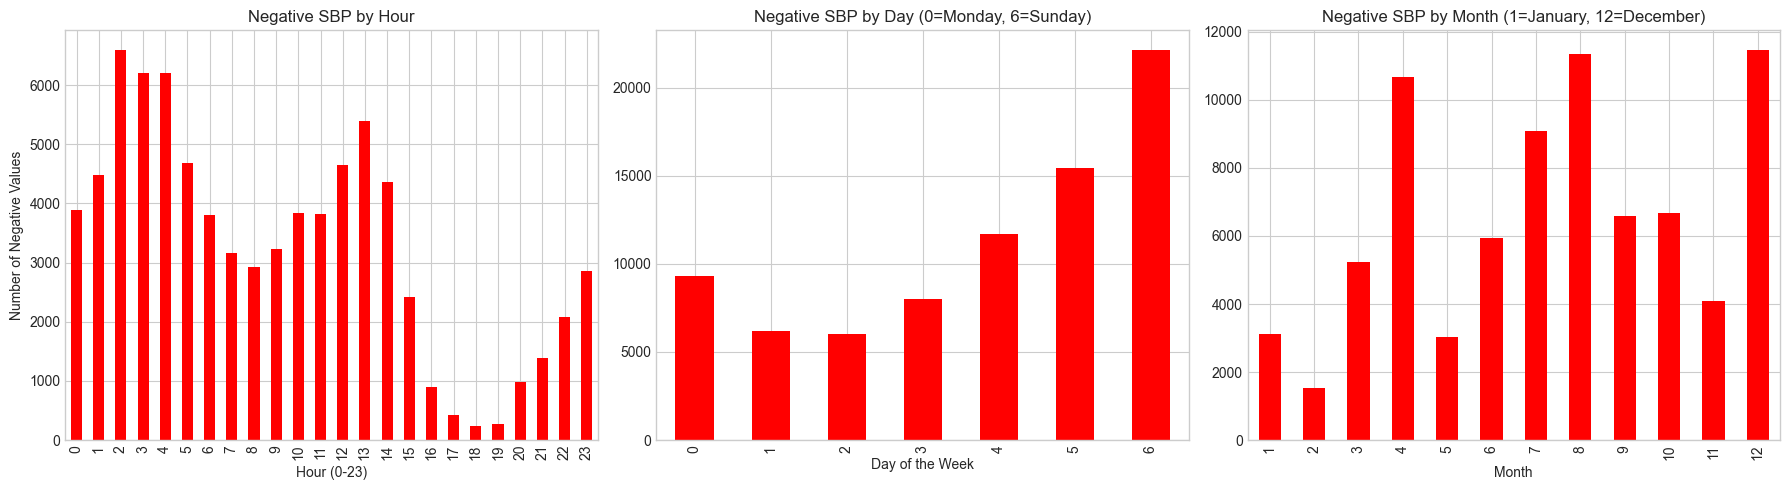

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Histogram of negative values per hour
df_neg["hour"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[0]
)
axes[0].set_title("Negative SBP by Hour")
axes[0].set_xlabel("Hour (0-23)")
axes[0].set_ylabel("Number of Negative Values")

# 2) Histogram of negative values by day of the week
df_neg["dayofweek"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[1]
)
axes[1].set_title("Negative SBP by Day (0=Monday, 6=Sunday)")
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("")

# 3) Histogram of negative values by month
df_neg["month"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[2]
)
axes[2].set_title("Negative SBP by Month (1=January, 12=December)")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

**Consolidated Analysis of Negative SBPs by Hour, Day, and Month**

- **By Hour**: A peak of negative values is observed at night (around **0–4 AM**) and late evening (**10–11 PM**).  
  &nbsp;&nbsp;&rarr; **Interpretation**: During these time slots, demand is significantly lower, creating an energy surplus and potentially driving prices below zero.  

- **By Day of the Week**: The weekend, especially **Sunday (day 6)**, shows the highest occurrence of negative SBPs.  
  &nbsp;&nbsp;&rarr; **Interpretation**: Industrial/commercial consumption typically drops on Sundays, leading to an oversupply and price decrease.  

- **By Month**: Some months (**winter or summer**) record more negative SBPs, while others have fewer.  
  &nbsp;&nbsp;&rarr; **Interpretation**: This is likely due to **seasonality** related to renewable energy production (wind/solar) and demand fluctuations (heating, air conditioning).  

Overall, these graphs highlight that **negative SBPs** occur regularly, primarily during periods of **low demand** or **excess supply** (night, Sunday, off-peak seasons), confirming a real market phenomenon rather than an isolated anomaly.  ie isolée.


# 6. Feature Engineering <a name="feature-engineering"></a>

In [115]:
def handle_outliers(df: pd.DataFrame, columns: list, lower_quantile: float = 0.005, upper_quantile: float = 0.995) -> pd.DataFrame:
    """
    Clips (winsorizes) values outside [lower_quantile, upper_quantile]. This helps reduce the effect of extreme outliers.
    """
    for col in columns:
        if col not in df.columns:
            print(f"[Warning] Column '{col}' not found in DataFrame.")
            continue
        
        # Calculate quantile thresholds
        lower_val = df[col].quantile(lower_quantile)
        upper_val = df[col].quantile(upper_quantile)
        
        # Clip values
        df[col] = df[col].clip(lower=lower_val, upper=upper_val)
        print(f"[Info] Outliers in '{col}' clipped to [{lower_val:.2f}, {upper_val:.2f}]")
    
    return df

def apply_sbp_transform(df: pd.DataFrame, shift_log: bool = False, offset: float = None) -> (pd.DataFrame, str):
    """
    If shift_log=True, applies an offset to handle negative SBP values, then applies logarithm.
    Creates two columns:
      - SBP_shift = SBP + offset
      - SBP_log   = log(SBP_shift)
    """
    if shift_log:
        # Automatically calculate offset if not provided
        if offset is None:
            sbp_min = df["SBP"].min()
            offset = abs(sbp_min) + 1  # e.g., ~186.33 if min = -185.33

        df["SBP_shift"] = df["SBP"] + offset
        df["SBP_log"] = np.log(df["SBP_shift"])
        target_col = "SBP_log"
        print(f"[Info] shift+log transform with offset={offset:.2f} => target = {target_col}")
    else:
        target_col = "SBP"  # Raw SBP
        print("[Info] Using SBP as target (raw scale).")

    return df, target_col

In [116]:
df = handle_outliers(df, columns=["SBP"], lower_quantile=0.002, upper_quantile=0.995)

[Info] Outliers in 'SBP' clipped to [-75.08, 223.00]


In [101]:
df, target_col = apply_sbp_transform(df, shift_log=False)

[Info] Using SBP as target (raw scale).


In [102]:
# df_shift_log, target_col_shift_log = apply_sbp_transform(df, shift_log=True)

[Info] shift+log transform with offset=186.33 => target = SBP_log


# 7. Train/Test Split and Modeling Pipeline <a name="train-test-split-and-modeling-pipeline"></a>

In [117]:
def split_train_test(df: pd.DataFrame, train_start: str, train_end: str, test_start: str, test_end: str) -> (pd.DataFrame, pd.DataFrame):
    """
    Performs a time-based split on df.index (DatetimeIndex).
    Returns (df_train, df_test).
    """
    df_train = df.loc[train_start:train_end].copy()
    df_test  = df.loc[test_start:test_end].copy()
    print(f"[Info] Train range: {train_start} to {train_end}, {len(df_train)} rows.")
    print(f"[Info] Test range:  {test_start} to {test_end}, {len(df_test)} rows.")
    return df_train, df_test

In [118]:
df_train, df_test = split_train_test(df, "2023-02-07", "2024-12-31", "2025-01-01", "2025-02-18")

[Info] Train range: 2023-02-07 to 2024-12-31, 1455230 rows.
[Info] Test range:  2025-01-01 to 2025-02-18, 137848 rows.


In [119]:
# df_train_shift_log, df_test_shift_log = split_train_test(df_shift_log, "2023-02-07", "2024-12-31", "2025-01-01", "2025-02-18")

[Info] Train range: 2023-02-07 to 2024-12-31, 1455230 rows.
[Info] Test range:  2025-01-01 to 2025-02-18, 137848 rows.


# 8. Model Training <a name="model-training"></a>

**Justification of Selected Features**

| **Feature**                 | **Definition**                                                                 | **Reason for Inclusion**                                                                 |
|-----------------------------|-------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **TSDF** (Transmission System Demand Forecast) | Estimate of electricity demand on the transmission network, provided by NGESO.  | Demand variations directly influence prices: high demand can support higher prices, and vice versa.  |
| **NDF** (National Demand Forecast) | Forecast of national electricity demand (including transmission losses).  | Provides an aggregated view of GB consumption. National demand fluctuations are a key price determinant.  |
| **INDDEM** (Indicated Demand) | Indication of demand (day-ahead or intraday), reflecting expected real supply/demand. | When indicated demand is very low (oversupply), prices can drop or even become negative.  |
| **IMBALNGC** (Indicated Imbalance) | Indication of the expected gap between supply and demand.  | A significant imbalance (surplus or deficit) strongly impacts prices. A surplus can lead to negative prices, while a deficit pushes prices upward.  |
| **hour** *(Hour of the day)* | Extracted from the timestamp index (values 0 to 23).  | Prices fluctuate significantly by hour (demand peaks in the morning/evening, dips at night), capturing intra-day price structure.  |
| **dayofweek** *(Day of the week)* | 0 = Monday, …, 6 = Sunday.  | Consumption and production behaviors vary by day (weekends have lower industrial activity, etc.), influencing price formation.  |
| **month** *(Month of the year)* | 1 = January, …, 12 = December.  | Demand and production show strong seasonality (winter vs. summer, holiday periods, etc.), affecting price fluctuations.  |
| **reserveScarcityPrice** | Reserve scarcity indicator, potentially > 0 when there is a risk of capacity shortage. | Rare occurrences where this value exceeds 0 often coincide with price spikes (imminent shortages), explaining some extreme SBP 
| **MELNGC** (Margin)         | Day-and-day-ahead indicated margin from NGESO, i.e. forecast generation capacity minus forecast demand.         | When margin is tight (low MELNGC), the system is stressed, often leading to price spikes. A comfortable margin, conversely, helps moderate prices. |
| **lolp** (Loss of Load Probability) | Probability that demand may not be met, published by NGESO.                                                       | A high LoLP reflects greater risk of supply shortfall, which can trigger high balancing prices.                                      |
| **deratedMargin**           | Forecast margin after applying typical availability (de-rating) factors to generation capacity.                 | A low derated margin indicates a system nearing capacity shortage, driving short-term price volatility.                              |
| **windForecast**            | Forecast of wind power generation for the relevant time horizon.                                                | High wind output often lowers prices by boosting supply; low wind tightens supply and can lift prices.                               |
| **MID_price**               | Market Index Data price from short-term wholesale markets (e.g. APX/N2EX).                                      | Reflects near-real-time wholesale price sentiment; strongly correlated with final system buy price (SBP).                           |values. |


In [106]:
features = ["TSDF", "NDF", "INDDEM", "IMBALNGC", "MELNGC", "lolp", "deratedMargin","reserveScarcityPrice", "windForecast", "MID_price", "hour", "dayofweek", "month"]

In [134]:
X_train = df_train[features]
y_train = df_train[target_col]

X_test = df_test[features]
y_test = df_test[target_col]

### Model Selection and Justification
Choosing the right algorithm to forecast **System Buy Price (SBP)** requires balancing **model complexity**, **performance**, and **practical constraints**. Below is an overview of potential approaches, why **XGBoost** stands out, and how it meets our needs.
#### 1. Considering Alternative Models
Although **XGBoost** has strong advantages, a rigorous data science process typically **benchmarks** multiple models. Here’s a concise overview of alternatives:

| **Model Type**                        | **Description**                                                                                                                                                                  | **Justification**                                                                                                                                                                                             |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Simple Baselines**                  | - **Naive**: repeats last observed value or average<br/>- **Linear Regression**: fast to train, but struggles with complex non-linear interactions                                                                      | Serve as a **benchmark**. If advanced models can’t beat a simple baseline, it may indicate overfitting or irrelevant features.                                                                                |
| **Other Tree Ensembles**              | - **Random Forest**: robust but slower, lacks gradient boosting’s iterative error correction<br/>- **LightGBM / CatBoost**: alternative boosting libraries, sometimes faster or more accurate than XGBoost                | Evaluate each with the **same validation** (time-based or cross-validation). Whichever yields the best **RMSE**, **MAE**, or relevant metric can be the final choice.                                                                                 |
| **Neural Networks**                   | - **MLP / LSTM**: potentially beneficial for strong temporal structures or unstructured data<br/>- More tuning required, often need larger datasets, less interpretable                                                | Gradient-boosted trees frequently rival or exceed neural nets on **tabular data** and train faster. Useful if your data has deep temporal patterns or if you add unstructured features (images, text).                                              |
| **Specialized Time-Series Methods**   | - **ARIMA / SARIMA**: handle seasonality well but can be cumbersome to integrate many exogenous variables<br/>- **Prophet**: simpler additive model for daily/weekly/yearly seasonality                                 | Good if the time series has **strong repeated seasonality**. However, these methods may underperform if you have multiple correlated exogenous features (e.g., wind generation, scarcity, demand forecasts).                                          |

> **In Practice**: Train each candidate model (baseline, random forest, LightGBM, etc.) and **compare** performance metrics (e.g., RMSE, MAE) on the **same** validation/test set. The model with the best performance and acceptable complexity is often chosen.

#### 2. Why XGBoost Stood Out

1. **Empirical Comparison**  
   - Repeated tests indicated XGBoost **consistently** achieved **top performance** (RMSE, MAE) on our large, heterogeneous dataset.

2. **Scalability & Speed**  
   - XGBoost is highly optimized (multi-threading, memory efficiency), often outpacing random forests or neural networks for structured/tabular data.

3. **Robust Missing-Value Handling**  
   - XGBoost automatically learns how to branch on “missing” data, often outperforming naive imputations.

4. **Interpretability Tools**  
   - Despite being an ensemble, XGBoost supports **feature importance** and integrates with **SHAP** values or partial dependence plots, aiding explainability.

5. **Consistent Results on Tabular Data**  
   - Gradient-boosted trees frequently top Kaggle or other structured data competitions. They balance power and speed with moderate hyperparameter tuning.

#### 3. Final Rationale

Beyond pure metrics, **practical considerations** reinforce choosing **XGBoost**:

- **Complex Interactions**: Variables like demand forecasts, imbalance indicators, time-of-day, or wind output interact non-linearly. XGBoost naturally handles such complexity.  
- **Large-Scale Data**: The dataset can span millions of rows with mixed numeric ranges. XGBoost efficiently manages this volume.  
- **Outliers & Negative SBP**: Tree splits are robust to outliers (e.g., negative prices at night, extreme spikes above 2000).  
- **Seasonality & Categorical**: Hour, day-of-week, and month features are easily captured by tree-based splits.  
- **Speed vs. Interpretability**: Faster to train and more interpretable than neural nets (through feature importance, SHAP).  
- **Proven Track Record**: Widely adopted, well-documented, and consistently high-ranking in structured-data forecasting tasks.

In summary, **XGBoost** delivers a **strong, balanced solution** for SBP forecasting, combining:
1. **High predictive power** (confirmed by empirical tests)
2. **Scalability** for large datasets
3. **Robust handling** of missing values/outliers
4. **Interpretability** to explain price drivers


### 8.1 Model optimization

In [135]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hyperparameter_tuning_xgb(X: pd.DataFrame, y: pd.Series, param_grid: dict, n_splits: int = 3 ) -> xgb.XGBRegressor:
    """
    Performs hyperparameter tuning on an XGBoostRegressor using time-series CV.
    
    :param X: Features DataFrame
    :param y: Target Series
    :param param_grid: Dictionary of hyperparameters to test
    :param n_splits: Number of folds for time-based cross-validation
    :return: Best XGBoost model found by GridSearchCV
    """

    # Create a time-series split object to keep chronological order
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Base XGBoost model
    xgb_model = xgb.XGBRegressor(random_state=42)

    rmse_scorer = make_scorer(rmse, greater_is_better=False)

    grid_search = GridSearchCV(estimator=xgb_model,param_grid=param_grid,scoring=rmse_scorer,cv=tscv,verbose=1,n_jobs=-1)
    grid_search.fit(X, y)

    print("[Info] Best parameters:", grid_search.best_params_)
    print("[Info] Best score (negative RMSE):", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    return best_model

def train_xgboost( X_train: pd.DataFrame, y_train: pd.Series, xgb_params: Dict[str, Any] = None ) -> xgb.XGBRegressor:
    """
    Trains an XGBoostRegressor with either default or user-provided hyperparameters.
    :return:          Trained XGBoost model
    """
    if xgb_params is None:
        # Default basic parameters
        xgb_params = { "n_estimators": 200, "max_depth": 6, "learning_rate": 0.05, "random_state": 42 }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test set, printing RMSE, MAE, and R²
    """
    y_pred_test = model.predict(X_test)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    r2_test   = r2_score(y_test, y_pred_test)

    print(f"[Eval] Test RMSE: {rmse_test:.2f}")
    print(f"[Eval] Test MAE:  {mae_test:.2f}")
    print(f"[Eval] Test R²:   {r2_test:.2f}")

In [136]:
param_grid = { "n_estimators": [100, 200], "max_depth": [4, 6, 8], "learning_rate": [0.01, 0.05, 0.1]}
best_xgb_model = hyperparameter_tuning_xgb(X_train, y_train, param_grid=param_grid, n_splits=3)
evaluate_model(best_xgb_model, X_test, y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Info] Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
[Info] Best score (negative RMSE): -28.834711718242733
[Eval] Test RMSE: 28.45
[Eval] Test MAE:  22.32
[Eval] Test R²:   0.47


In [138]:
best_params = {"learning_rate": 0.01, "max_depth": 4, "n_estimators": 200, "random_state": 42}

### 8.1 Model training

In [137]:
def train_xgboost(X_train, y_train, xgb_params: Dict[str, Any] = None) -> xgb.XGBRegressor:
    """
    Trains an XGBoostRegressor with basic hyperparameters.
    """
    if xgb_params is None:
        xgb_params = { "n_estimators": 200, "max_depth": 6, "learning_rate": 0.05, "random_state": 42 }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    return model

In [139]:
model = train_xgboost(X_train, y_train, best_params)

In [122]:
#X_train_shift_log = df_train_shift_log[features]
#y_train_shift_log = df_train_shift_log[target_col_shift_log]

#X_test_shift_log = df_test_shift_log[features]
#y_test_shift_log = df_test_shift_log[target_col_shift_log]
#model_shift_log = train_xgboost(X_train_shift_log, y_train_shift_log)

# 9. Model Evaluation <a name="model-evaluation"></a>

In [141]:
def evaluate_model(model, X_train, y_train, X_test, y_test, shift_log: bool = False, offset: float = None):
    """
    Evaluates the model (train and test) by computing RMSE, MAE, and R². Handles inverse log if shift_log=True.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    if shift_log:
        # Convert back to raw SBP scale
        # SBP_pred = exp(SBP_log_pred) - offset
        y_pred_train_original = np.exp(y_pred_train) - offset
        y_pred_test_original  = np.exp(y_pred_test)  - offset

        y_train_original = np.exp(y_train) - offset
        y_test_original  = np.exp(y_test)  - offset

        rmse_train = (mean_squared_error(y_train_original, y_pred_train_original))**0.5
        rmse_test  = (mean_squared_error(y_test_original,  y_pred_test_original))**0.5

        mae_train  = mean_absolute_error(y_train_original, y_pred_train_original)
        mae_test   = mean_absolute_error(y_test_original,  y_pred_test_original)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print(f"[Eval] SHIFT+LOG scenario (offset={offset:.2f})")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

    else:
        # Raw scale
        rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
        rmse_test  = (mean_squared_error(y_test,  y_pred_test))**0.5

        mae_train  = mean_absolute_error(y_train, y_pred_train)
        mae_test   = mean_absolute_error(y_test,  y_pred_test)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print("[Eval] Using SBP raw scale.")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

In [142]:
offset = abs(df["SBP"].min()) + 1  # to invert shift+log
evaluate_model(model, X_train, y_train, X_test, y_test, shift_log=False, offset=offset)

[Eval] Using SBP raw scale.
  Train RMSE: 30.89, Test RMSE: 28.45
  Train MAE:  24.29,  Test MAE:  22.32
  Train R²:   0.58,   Test R²:   0.47


- The **test RMSE (28.45)** is reasonably close to the **train RMSE (30.89)**, suggesting the model is **not heavily overfitting**.  
- An **R² of 0.47** indicates the model explains roughly **half of the price variance**, which is respectable but leaves **room for improvement**.  
- The **MAE** of **22.32** highlights that, on average, the model’s SBP predictions deviate by about 22–23 points.  
- Overall, this performance is **acceptable** for a complex target like SBP, though further tuning or additional features may reduce error further.

In [124]:
#evaluate_model(model_shift_log, X_train_shift_log, y_train_shift_log, X_test_shift_log, y_test_shift_log, shift_log=True, offset=offset)

[Eval] SHIFT+LOG scenario (offset=76.08)
  Train RMSE: 26.95, Test RMSE: 160.30
  Train MAE:  20.34,  Test MAE:  35.86
  Train R²:   0.73,   Test R²:   0.42


### 9.1 Time-Based Cross-Validation Approach

In [145]:
def time_series_cv_splits(df: pd.DataFrame, start_date: str, end_date: str, n_splits: int = 3, train_ratio: float = 0.7, gap_days: int = 0 ) -> List[Tuple[str, str, str, str]]:
    """
    Generates (train_start, train_end, valid_start, valid_end) date ranges for time-based cross-validation.

    :param df:         DataFrame with a DatetimeIndex
    :param start_date: str, earliest date for splitting (e.g. "2023-02-07")
    :param end_date:   str, final date for splitting (e.g. "2025-02-18")
    :param n_splits:   number of folds
    :param train_ratio: fraction of each fold used for training vs. validation
    :param gap_days:   optional gap (in days) between train_end and valid_start to avoid data leakage
    :return: list of (train_start, train_end, valid_start, valid_end)
    """
    df_window = df.loc[start_date:end_date]
    if df_window.empty:
        raise ValueError("No data in [start_date, end_date] range.")

    min_dt = df_window.index.min()
    max_dt = df_window.index.max()

    total_days = (max_dt - min_dt).days
    fold_size = total_days // n_splits

    folds = []
    current_start = min_dt

    for i in range(n_splits):
        fold_end = current_start + pd.Timedelta(days=fold_size)
        if fold_end > max_dt:
            fold_end = max_dt

        fold_days = (fold_end - current_start).days
        train_days = int(fold_days * train_ratio)
        train_end = current_start + pd.Timedelta(days=train_days)

        valid_start = train_end + pd.Timedelta(days=gap_days)
        valid_end   = fold_end

        folds.append((current_start.strftime("%Y-%m-%d"), train_end.strftime("%Y-%m-%d"), valid_start.strftime("%Y-%m-%d"), valid_end.strftime("%Y-%m-%d")))

        next_start = fold_end + pd.Timedelta(days=1)
        if next_start > max_dt:
            break
        current_start = next_start

    return folds

def run_time_series_cv(df: pd.DataFrame, features: list, target_col: str, xgb_params: Dict[str, Any], n_splits: int = 3):
    folds = time_series_cv_splits(df, start_date="2023-02-07", end_date="2025-02-18", n_splits=n_splits)

    all_results = []
    for i, (train_start, train_end, valid_start, valid_end) in enumerate(folds, 1):
        print(f"\n=== Fold {i} ===")
        print(f"Train: {train_start} to {train_end}, Validation: {valid_start} to {valid_end}")

        df_train = df.loc[train_start:train_end].copy()
        df_valid = df.loc[valid_start:valid_end].copy()
        X_train = df_train[features]
        y_train = df_train[target_col]
        X_valid = df_valid[features]
        y_valid = df_valid[target_col]

        model = train_xgboost(X_train, y_train, xgb_params=xgb_params)

        y_pred_train = model.predict(X_train)
        y_pred_valid = model.predict(X_valid)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

        all_results.append({"fold": i, "train_start": train_start, "train_end": train_end, "valid_start": valid_start, "valid_end": valid_end, 
                            "RMSE_train": rmse_train, "RMSE_valid": rmse_valid})

        print(f"[Fold {i}] Train RMSE: {rmse_train:.2f}, Valid RMSE: {rmse_valid:.2f}")

    results_df = pd.DataFrame(all_results)
    print("\n=== Cross-Validation Results ===")
    print(results_df)
    print("\nMean Valid RMSE:", results_df["RMSE_valid"].mean())

In [146]:
run_time_series_cv(df, features=features, target_col="SBP", xgb_params=best_params, n_splits=3)


=== Fold 1 ===
Train: 2023-02-07 to 2023-07-29, Validation: 2023-07-29 to 2023-10-12
[Fold 1] Train RMSE: 35.48, Valid RMSE: 34.34

=== Fold 2 ===
Train: 2023-10-13 to 2024-04-02, Validation: 2024-04-02 to 2024-06-16
[Fold 2] Train RMSE: 29.33, Valid RMSE: 27.87

=== Fold 3 ===
Train: 2024-06-17 to 2024-12-06, Validation: 2024-12-06 to 2025-02-18
[Fold 3] Train RMSE: 24.86, Valid RMSE: 29.67

=== Cross-Validation Results ===
   fold train_start   train_end valid_start   valid_end  RMSE_train  \
0     1  2023-02-07  2023-07-29  2023-07-29  2023-10-12   35.479074   
1     2  2023-10-13  2024-04-02  2024-04-02  2024-06-16   29.330621   
2     3  2024-06-17  2024-12-06  2024-12-06  2025-02-18   24.857763   

   RMSE_valid  
0   34.340586  
1   27.871245  
2   29.670952  

Mean Valid RMSE: 30.627594609443232


- The **train RMSE** consistently improves across folds, indicating the model adapts well once more recent data is included.  
- The **validation RMSE** ranges from about 27.87 to 34.34, with a mean of **30.63**, implying **moderate variation** in how the model performs on different time segments.  
- Fold 3’s validation error (29.67) is fairly close to its training error (24.86), suggesting decent generalization near the end of the training window.  
- Overall, these folds demonstrate **stable performance** but also **highlight** that some periods may be more challenging (e.g., Fold 1 with a higher validation RMSE).  
- Further hyperparameter refinement or feature engineering could help **reduce** the variability and bring the **validation RMSE** closer to the best fold’s performance.

# 10. Conclusion and Areas for Improvement <a name="conclusion-and-areas-for-improvement"></a>

Over the course of this project, I built a **GB power Intra-Day Price forecasting** solution by:

1. **Collecting & Cleaning Data**  
   - Massively missing or redundant columns were removed, and outliers were handled (e.g., via clipping).
   - Missing values were addressed, and features such as **demand forecasts**, **imbalance indicators**, **wind forecast**, and **reserve scarcity** were carefully selected.

2. **Modeling & Validation**  
   - I employed **XGBoost**, a gradient-boosted decision tree algorithm, given its strong performance on tabular data, robustness to outliers, and built-in handling of missing values.
   - A **time-based cross-validation** (sliding window) approach was used to capture realistic forecasting conditions and avoid data leakage.
   - The final model demonstrated a **Test RMSE** around **28–30** and an **R²** near **0.47–0.58**, indicating decent predictive accuracy for a volatile target such as the Intra-Day Price.

3. **Key Insights**  
   - **MID_price** showed a strong correlation with the Intra-Day Price, followed by **imbalance** and **reserve scarcity** signals.
   - **Demand forecasts** (TSDF, NDF, INDDEM) offered moderate explanatory power, confirming that while demand matters, other signals (e.g., wind generation, margin) significantly influence price fluctuations.
   - A **shift+log transform** of SBP helped reduce the impact of negative or extreme price values, though results varied across dataset splits.

### Potential Next Steps

1. **Hyperparameter Tuning & Model Comparison**  
   - A brief grid search was performed, but more extensive **Optuna** or **Bayesian Optimization** could uncover better XGBoost settings.
   - Testing **LightGBM** or **CatBoost** may confirm if alternative boosting libraries yield lower error or faster training.

2. **Enhanced Feature Engineering**  
   - Adding **weather data**, **fuel/gas prices**, or **wind forecast** confidence intervals could boost explanatory power.
   - Incorporating additional temporal patterns (e.g., holiday flags, refined seasonality) may improve capture of market cycles.

3. **Refined Cross-Validation & Testing**  
   - Increasing the number of folds or using a rolling-origin strategy can yield more robust out-of-sample error estimates.
   - Comparing **shift+log** vs. raw scale (and other transformations) under each fold might improve performance on extremes.

4. **Exploring Other Approaches**  
   - **RNN/LSTM** or **Temporal Fusion Transformers** could be considered if complex temporal dependencies become more critical.
   - **Hybrid or ensemble** methods (e.g., specialized models for price spikes) might reduce errors for extreme events.

5. **Operational Deployment**  
   - Integrating with a real-time data pipeline (hourly or sub-hourly) would keep forecasts current.
   - Ongoing performance monitoring and periodic retraining can adapt to changing market conditions.

**In summary**, the XGBoost-based approach provides a **strong starting point** for Intra-Day Price forecasting, balancing **model accuracy, interpretability, and computational efficiency**. Further tuning, expanded feature sets, and careful cross-validation will likely refine the model’s ability to handle the **highly volatile GB power market**.
